In [0]:
import numpy as np

import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.linear_model as lm
import statsmodels.api as sm
import statsmodels.tsa as tsa
from fbprophet import Prophet
# if Prophet crashes, visit this page:
# https://github.com/dr-prodigy/python-holidays/issues/277

!pip install dtaidistance
from dtaidistance import dtw
from sklearn import metrics
from sklearn.model_selection import train_test_split

import itertools
from tqdm import tqdm

     |████████████████████████████████| 327kB 5.0MB/s 
  Created wheel for dtaidistance: filename=dtaidistance-1.2.3-cp36-cp36m-linux_x86_64.whl size=631157 sha256=b7245f5afb2fe7c951d40a8bee9fb5ba31f6a960337cdd834fff0726b30e2ceb
  Stored in directory: /root/.cache/pip/wheels/9f/9a/74/42c5b9dc714bb5a70b426df08cc860e6a741bc199004873e1b
Successfully built dtaidistance


# Upload data

### a) Upload from drive

In [0]:
from google.colab import drive

drive.mount('/content/drive')

In [0]:
# drive/My Drive/ is drive root

### b) Direct upload

In [0]:
from google.colab import files

upl = files.upload()

Saving general1.xlsx to general1.xlsx


### Create dataframe

In [0]:
df = pd.read_excel("general1.xlsx", sheet_name="remove_na")
df = df.dropna()
df.head()

,Country,Code,Year,Month,Economic (GDP) growth percent,Industrial production annual percent change,Retail sales Y-on-Y,Household consumption billion currency units,Consumption as percent of GDP,Consumption growth,Investment billion currency units,Investment as percent of GDP,Investment growth,CPI,CPI monthly percent change,CPI yearly percent change,Employment million people,Unemployment rate percent,Minimum wage,Foreign exchange reserves billion currency units,Government expenditure billion currency units,NBU interest rate
0,Ukraine,UKR,2007,3,10.6,6.9,29.0,88.03,63.13,31.24,33.50,24.03,48.26,60.19,0.17,10.06,20.54,7.4,400.0,22.99,24.47,8.5
1,Ukraine,UKR,2007,6,9.7,7.0,25.0,98.86,59.24,28.85,45.54,27.29,47.95,61.85,2.23,12.88,21.12,5.8,420.0,25.91,31.39,8.0
2,Ukraine,UKR,2007,9,4.4,5.3,29.7,110.38,55.32,29.06,56.19,28.16,48.11,64.44,2.14,14.36,21.56,5.4,440.0,30.67,30.56,8.0
3,Ukraine,UKR,2007,12,6.9,0.3,27.6,132.36,61.59,38.47,63.12,29.37,48.30,69.21,1.99,16.61,20.40,6.9,460.0,32.48,42.55,8.0
4,Ukraine,UKR,2008,3,8.5,2.3,24.7,129.11,67.43,46.67,51.20,26.74,52.82,75.96,3.83,26.21,20.72,7.1,515.0,33.23,32.46,10.0


In [0]:
df.tail()

,Country,Code,Year,Month,Economic (GDP) growth percent,Industrial production annual percent change,Retail sales Y-on-Y,Household consumption billion currency units,Consumption as percent of GDP,Consumption growth,Investment billion currency units,Investment as percent of GDP,Investment growth,CPI,CPI monthly percent change,CPI yearly percent change,Employment million people,Unemployment rate percent,Minimum wage,Foreign exchange reserves billion currency units,Government expenditure billion currency units,NBU interest rate
45,Ukraine,UKR,2018,6,3.8,2.9,5.8,577.15,71.18,21.03,139.70,17.23,35.85,259.8,0.00,10.41,16.53,8.3,3723.0,17.98,188.71,17.0
46,Ukraine,UKR,2018,9,2.8,-0.7,6.6,644.80,64.81,24.22,153.66,15.45,29.34,262.9,1.90,8.91,16.66,8.0,3723.0,16.64,158.52,18.0
47,Ukraine,UKR,2018,12,3.5,-2.8,4.5,702.65,67.05,21.04,214.29,20.45,23.13,273.3,0.81,9.76,16.22,9.3,3723.0,20.82,233.99,18.0
48,Ukraine,UKR,2019,3,2.5,2.1,9.5,664.63,82.28,24.64,126.37,15.64,22.42,279.9,0.90,8.57,16.26,9.2,4173.0,20.63,168.77,18.0
49,Ukraine,UKR,2019,6,4.6,-2.3,14.8,708.25,76.34,22.72,155.07,16.71,11.00,283.3,-0.49,9.05,16.71,7.8,4173.0,20.64,200.05,17.5


### Create date indices

In [0]:
idx_start = '2007-3-1'
idx_end   = '2019-9-1'
idx = pd.date_range(idx_start, idx_end, freq='Q')
date_index = pd.DatetimeIndex(idx)

In [0]:
df['Date'] = idx

### Create target variables

1. CPI
2. CPI monthly percent change
3. CPI yearly percent change

In [0]:
y_CPI = df['CPI']
y_CPI.index = date_index

y_CPI_m = df['CPI monthly percent change']
y_CPI_m.index = date_index

y_CPI_y = df['CPI yearly percent change']
y_CPI_y.index = date_index

### Create regressors variable

In [0]:
df.columns

Index(['Country', 'Code', 'Year', 'Month', 'Economic (GDP) growth percent',
       'Industrial production annual percent change', 'Retail sales Y-on-Y',
       'Household consumption billion currency units',
       'Consumption as percent of GDP', 'Consumption growth',
       'Investment billion currency units', 'Investment as percent of GDP',
       'Investment growth', 'CPI', 'CPI monthly percent change',
       'CPI yearly percent change', 'Employment million people',
       'Unemployment rate percent', 'Minimum wage',
       'Foreign exchange reserves billion currency units',
       'Government expenditure billion currency units', 'NBU interest rate',
       'Date'],
      dtype='object')

In [0]:
x = df.copy()
x = x.drop([
            'Country', 'Code',
            'Year', 'Month', 'Date',
            'CPI',
            'CPI monthly percent change',
            'CPI yearly percent change'
], axis=1)
x.index = date_index

### Create merged variable for further analysis

In [0]:
xy_CPI   = x.assign(CPI=y_CPI)
xy_CPI_m = x.assign(CPIm= y_CPI_m)
xy_CPI_y = x.assign(CPIy=y_CPI_y)

## Split training data

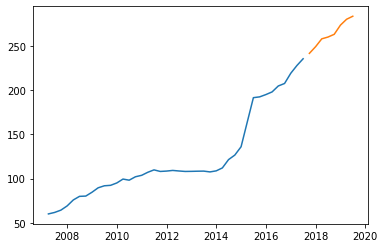

In [0]:
y_CPI_train, y_CPI_test = train_test_split(y_CPI, test_size=0.15, shuffle=False)
fig, ax = plt.subplots()
ax.plot(y_CPI_train.index, y_CPI_train)
ax.plot(y_CPI_test.index, y_CPI_test)

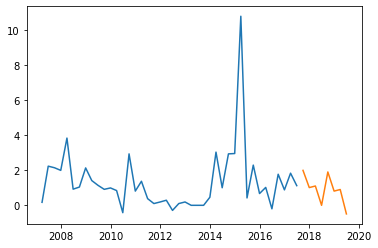

In [0]:
y_CPIm_train, y_CPIm_test = train_test_split(y_CPI_m, test_size=0.15, shuffle=False)
fig, ax = plt.subplots()
ax.plot(y_CPIm_train.index, y_CPIm_train)
ax.plot(y_CPIm_test.index, y_CPIm_test)

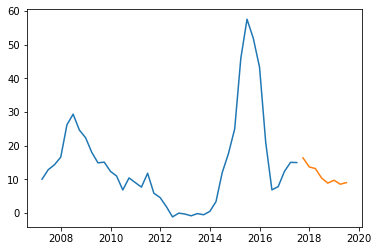

In [0]:
y_CPIy_train, y_CPIy_test = train_test_split(y_CPI_y, test_size=0.15, shuffle=False)
fig, ax = plt.subplots()
ax.plot(y_CPIy_train.index, y_CPIy_train)
ax.plot(y_CPIy_test.index, y_CPIy_test)

In [0]:
# manual split needed
x_train = x.loc[y_CPI_train.index,]
x_test  = x.loc[y_CPI_test.index, ]

In [0]:
# manual split for VARMA
xy_CPI_train = xy_CPI.loc[y_CPI_train.index,]
xy_CPI_test = xy_CPI.loc[y_CPI_test.index, ]

xy_CPIm_train = xy_CPI_m.loc[y_CPI_train.index,]
xy_CPIm_test = xy_CPI_m.loc[y_CPI_test.index, ]

xy_CPIy_train = xy_CPI_m.loc[y_CPI_train.index,]
xy_CPIy_test = xy_CPI_m.loc[y_CPI_test.index, ]

In [0]:
# single multitargeted Y for regression
y_train = 
y_train = y_CPI_train.merge(y_CPIm_train)
y_train = y_train.merge(y_CPIy_train)

y_test = y_CPI_test.merge(y_CPIm_test)
y_test = y_test.merge(y_CPIy_test)

AttributeError: ignored

# Visual analysis

### Define some helpful functions

Visualisation of:

1. Rolling mean
2. Autocorrelation
3. Seasonal decomposition
4. Pair plot
5. Correlation plot

In [0]:
# rolling mean
def rolling(x, window=12): 
    # Determining rolling statistics
    rolmean = x.rolling(window=window, center=False).mean()
    # rolstd = x.rolling(window=12, center=False).std() 
    
    # Plot rolling statistics
    orig = plt.plot(x.values, color='blue', label='Original') 
    mean = plt.plot(rolmean.values, color='red', label='Rolling Mean') 
    # std = plt.plot(rolstd.values, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [0]:
# autocorrelation
def autocorr(x, max_lag=36):
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(x.values.squeeze(), lags=max_lag, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(x, lags=max_lag, ax=ax2)

In [0]:
# seasonal decomposition
def seasonal(x):
    decompose = tsa.seasonal.seasonal_decompose(x)

    fig, ax = plt.subplots(nrows=4, figsize=(15,15))
    ax[0].plot(x.index, decompose.observed)
    ax[0].set_title('observed')
    ax[1].plot(x.index, decompose.seasonal)
    ax[1].set_title('seasonal')
    ax[2].plot(x.index, decompose.trend)
    ax[2].set_title('trend')
    ax[3].plot(x.index, decompose.resid)
    ax[3].set_title('residuals')
    fig.show()

In [0]:
# pairplot
def pairplot(df):
    plt.figure(figsize=(20,20))
    sns.pairplot(df)
    plt.show()

In [0]:
# corrplot
def corrplot(df):
    # Compute the correlation matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # plot
    plt.figure(figsize=(20,20))
    sns.heatmap(corr, mask=mask, annot=True, xticklabels=True, yticklabels=True)
    plt.show()

    # make annotation manually
    # print(*df.columns, sep='\n')

### 1. CPI

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_CPI.index, y=y_CPI,
                    mode='lines',
                    name='CPI'))

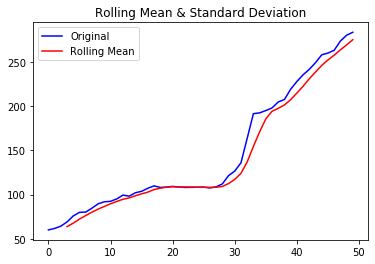

In [0]:
rolling(y_CPI, window=4)

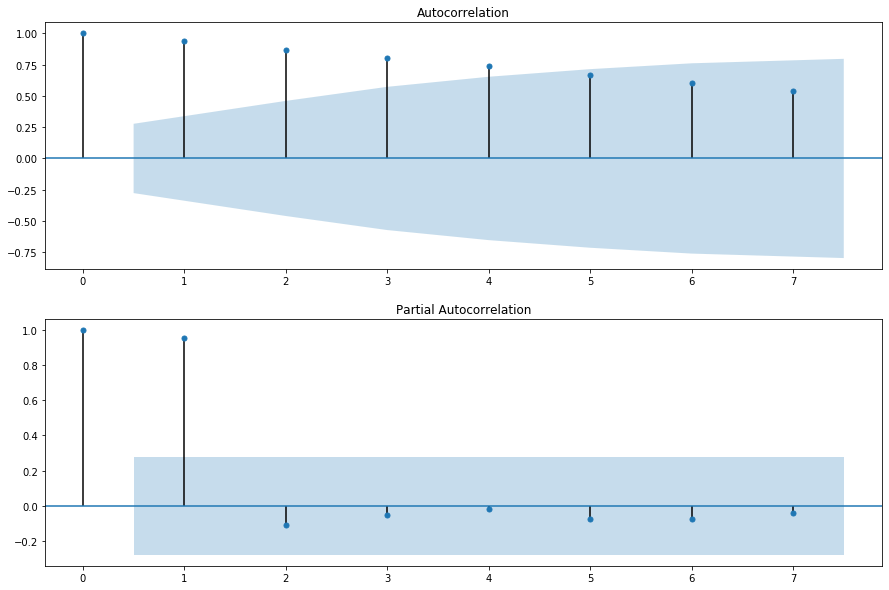

In [0]:
autocorr(y_CPI, max_lag=7)

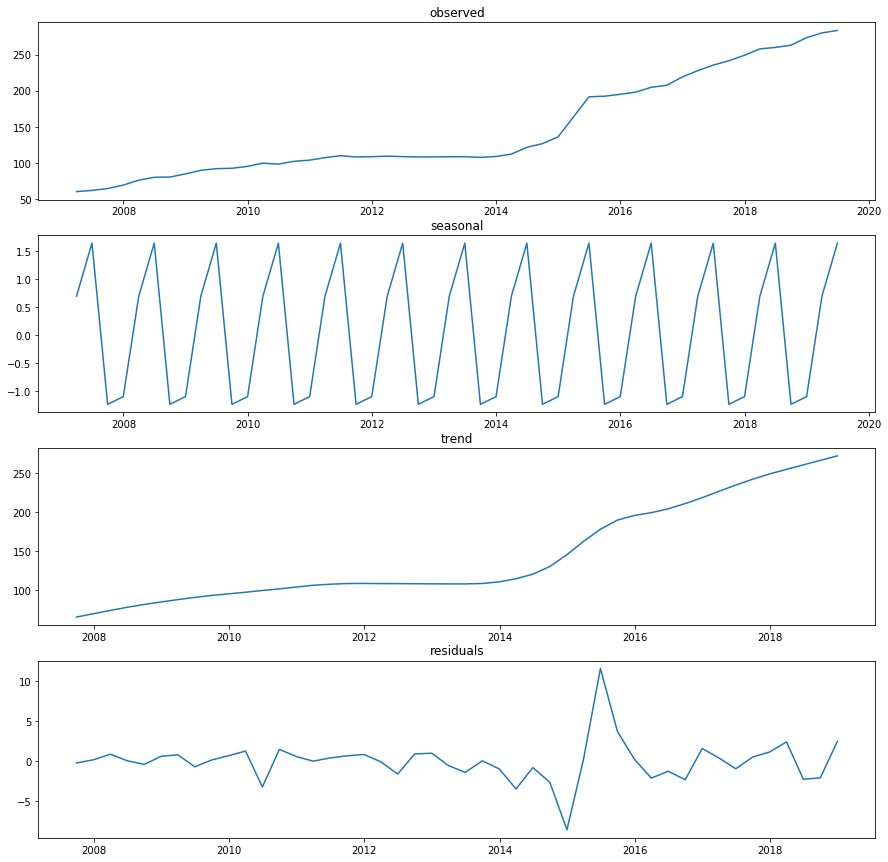

In [0]:
seasonal(y_CPI)

<Figure size 1440x1440 with 0 Axes>

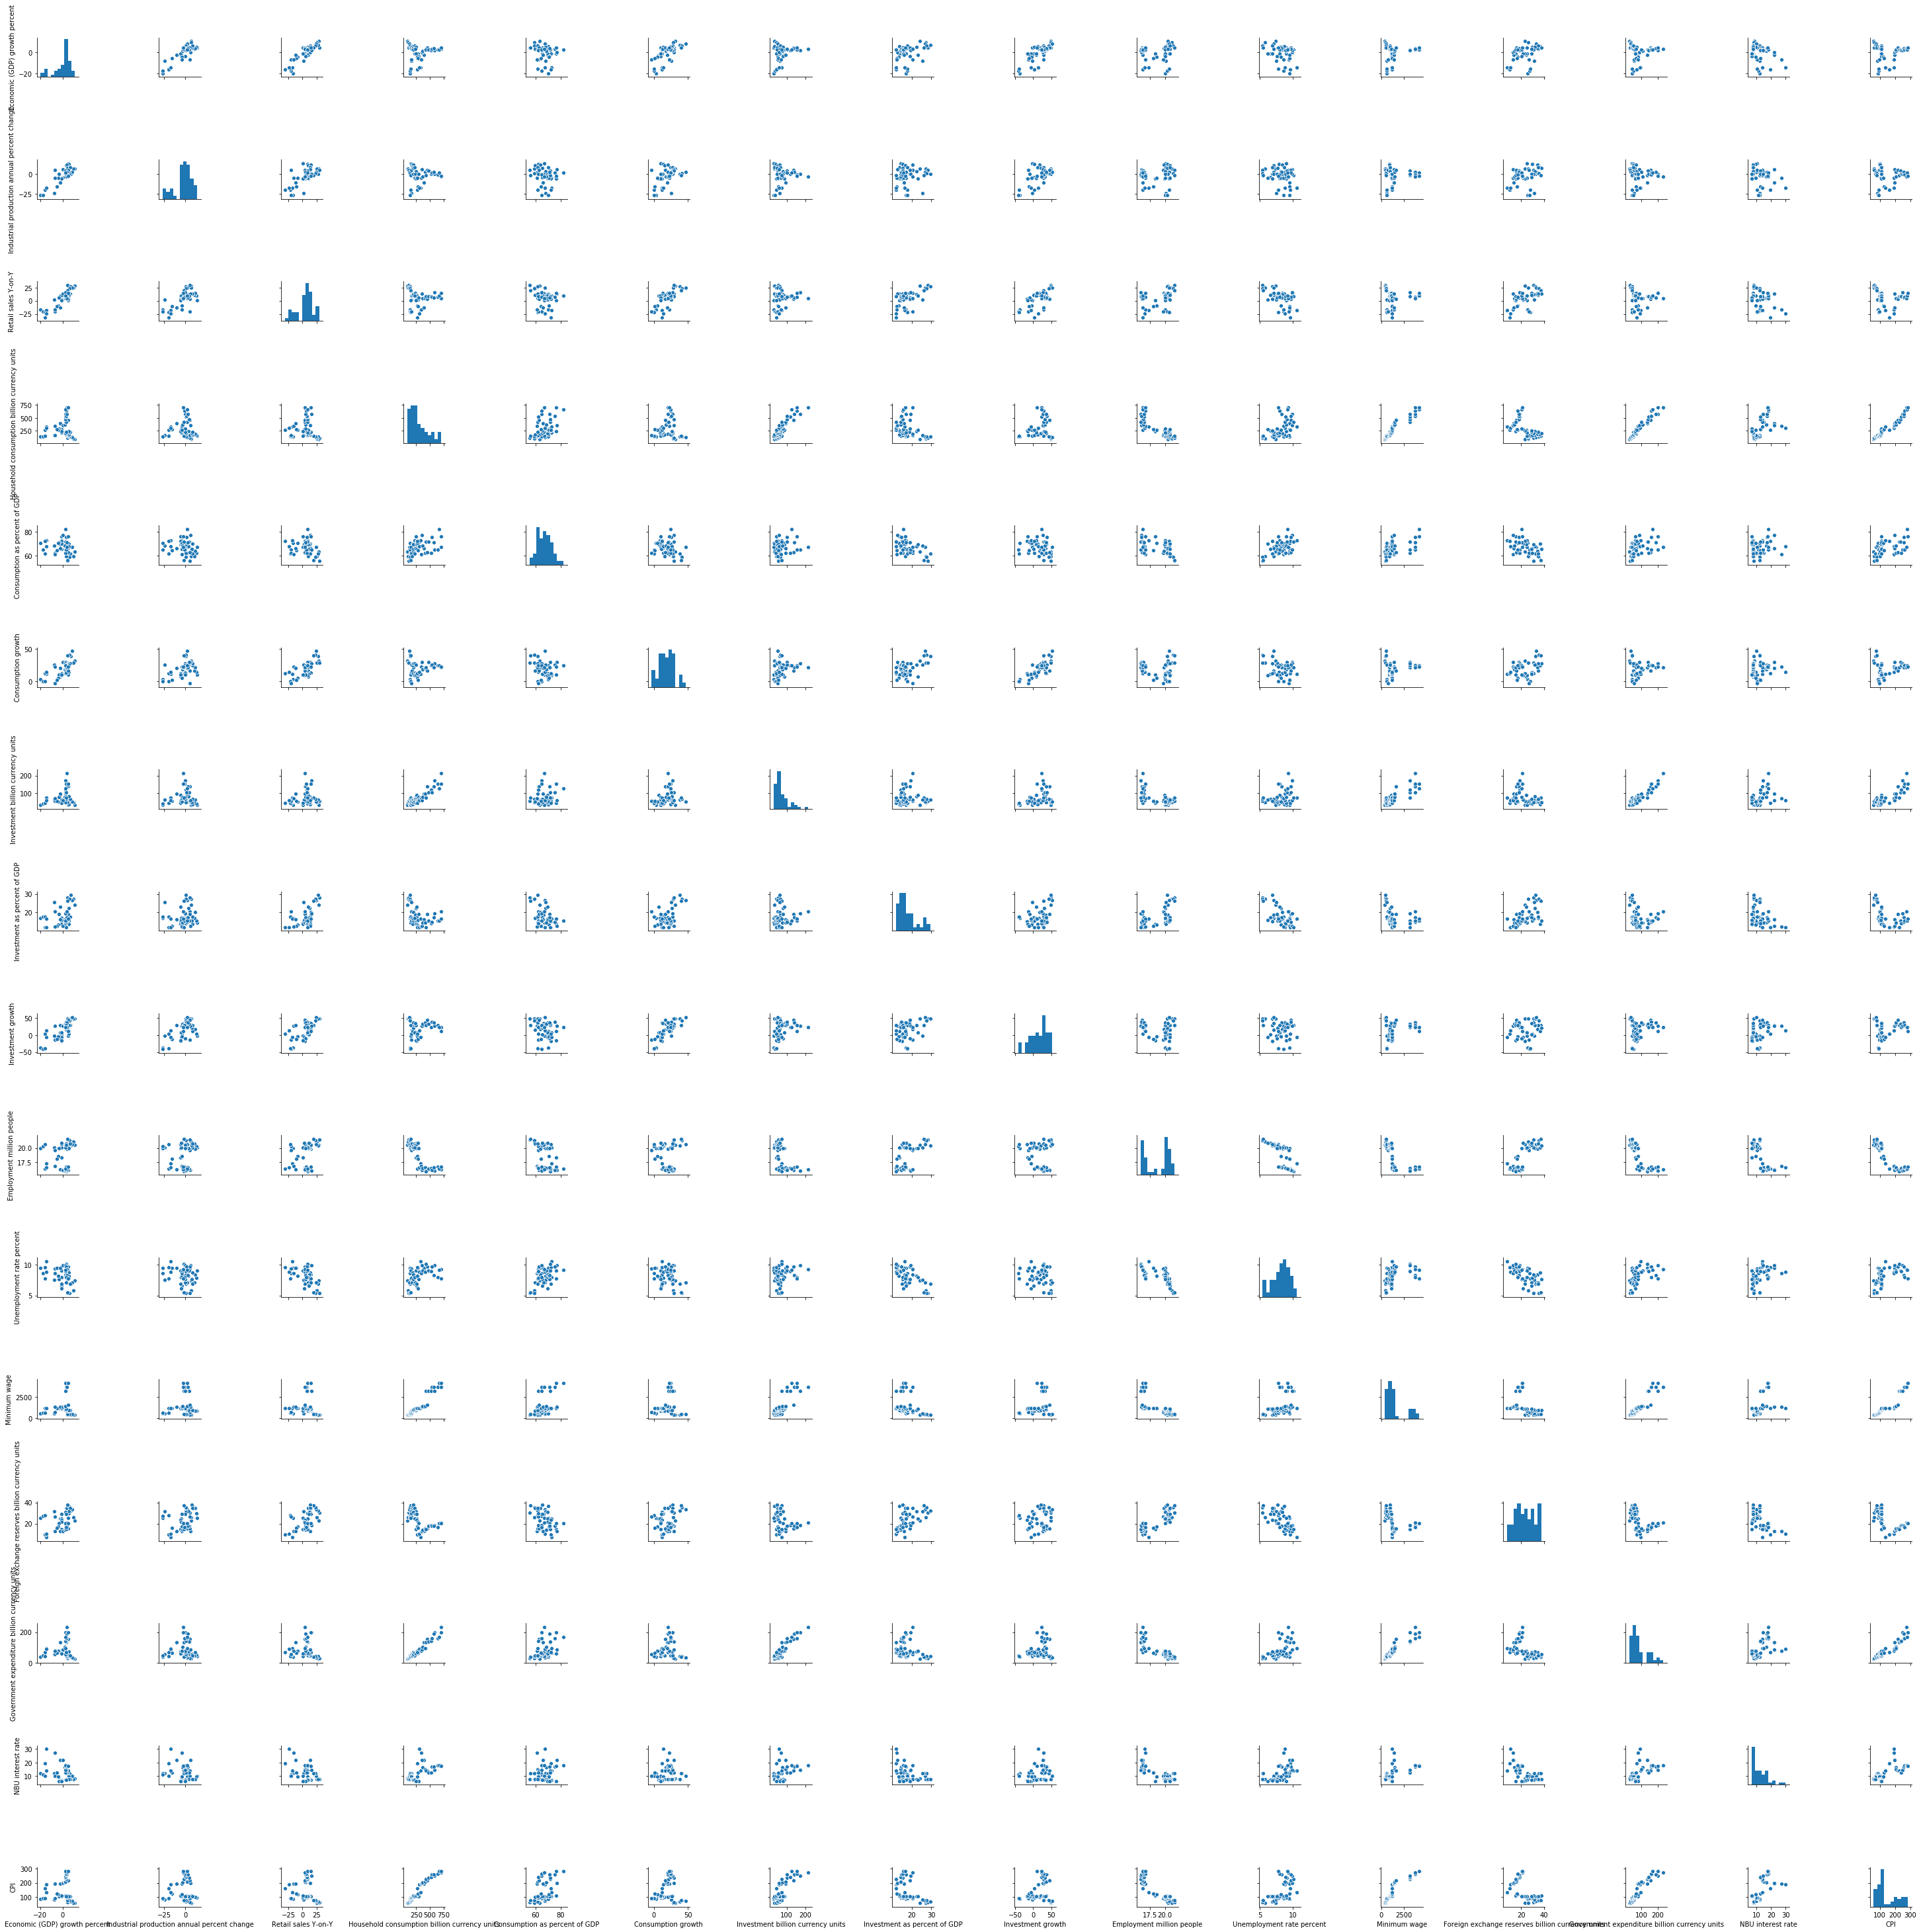

In [0]:
pairplot(xy_CPI)

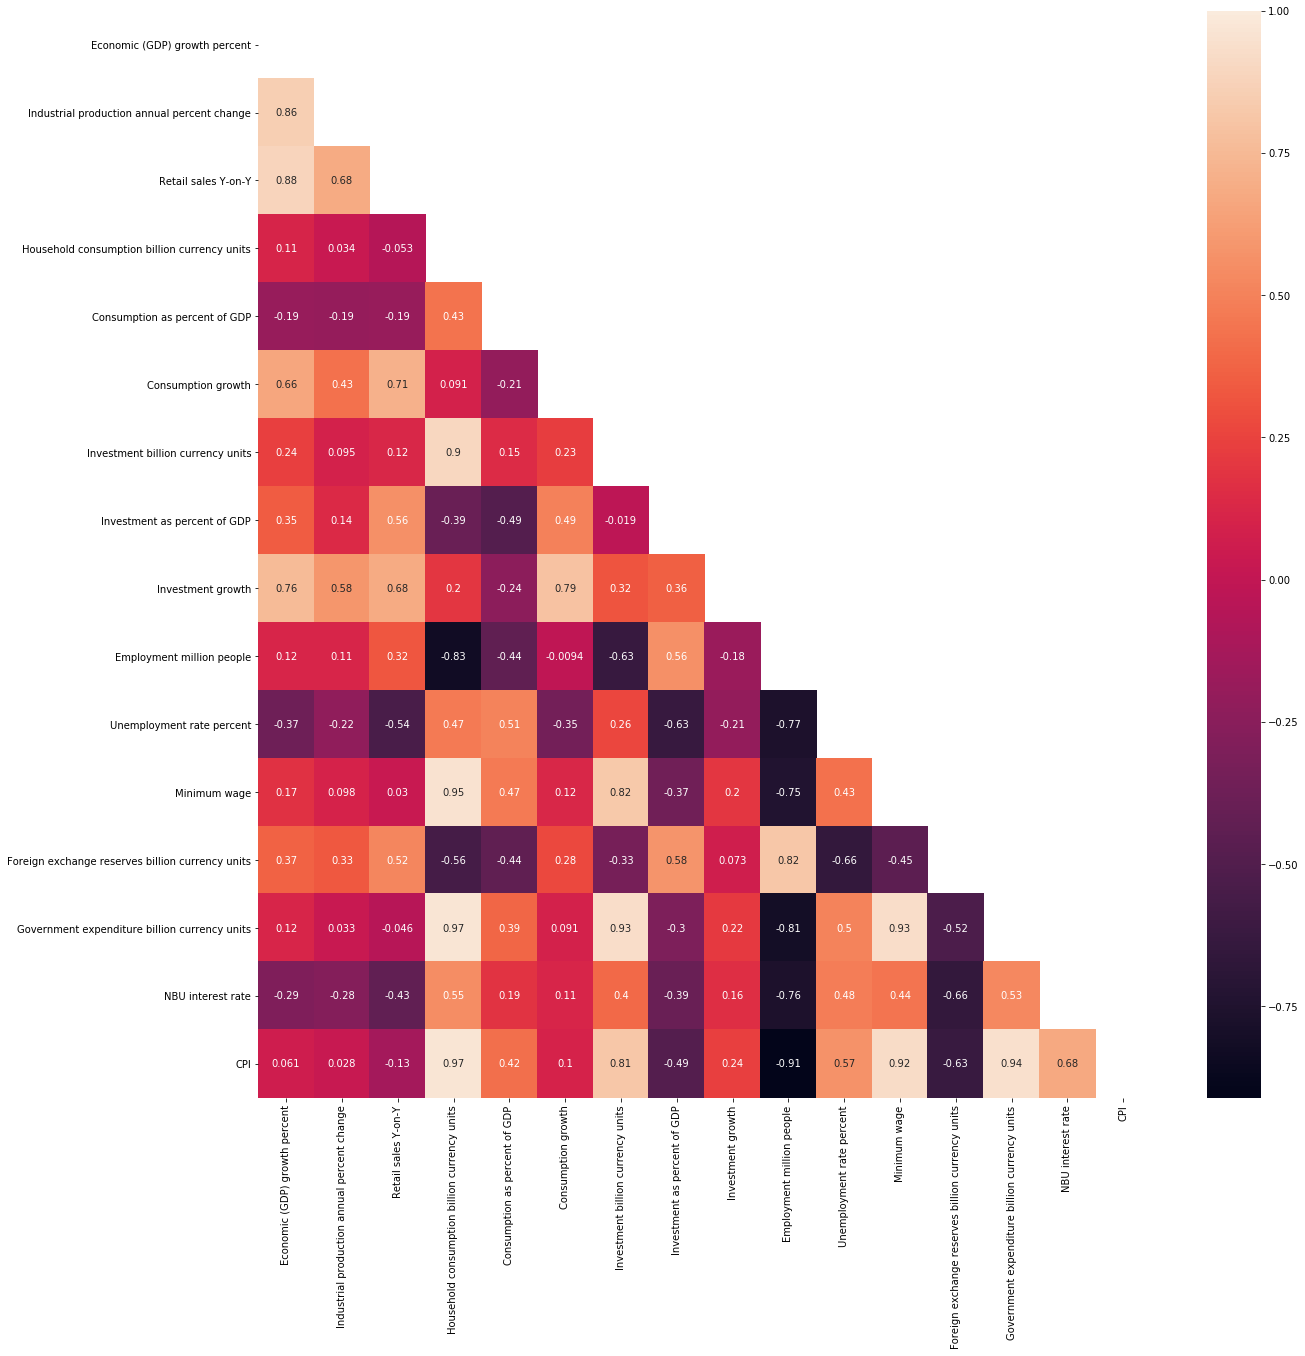

In [0]:
corrplot(xy_CPI)

### 2. CPI monthly percent change

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_CPI_m.index, y=y_CPI_m,
                    mode='lines',
                    name='CPI monthly percent change'))

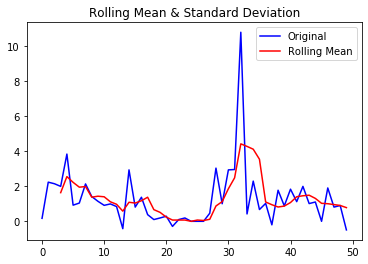

In [0]:
rolling(y_CPI_m, window=4)

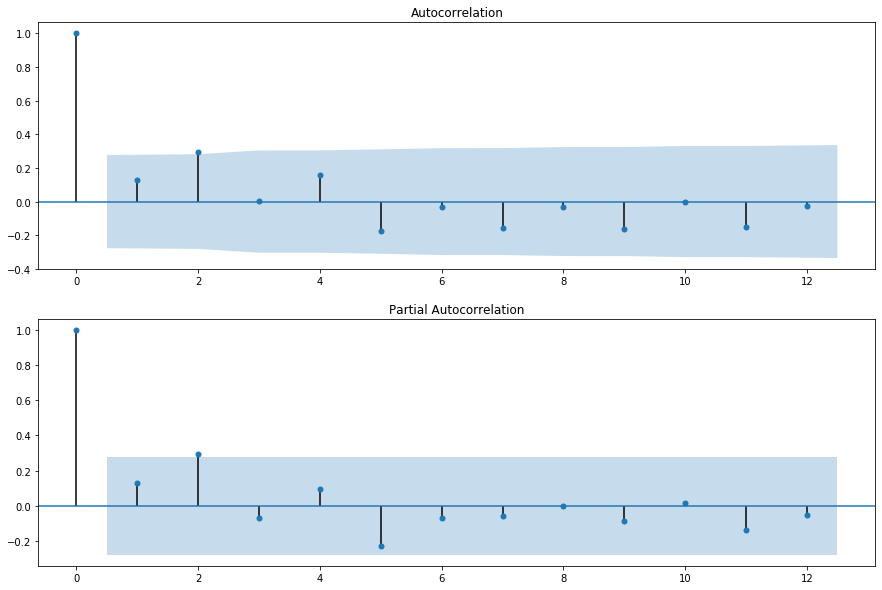

In [0]:
autocorr(y_CPI_m, max_lag=12)

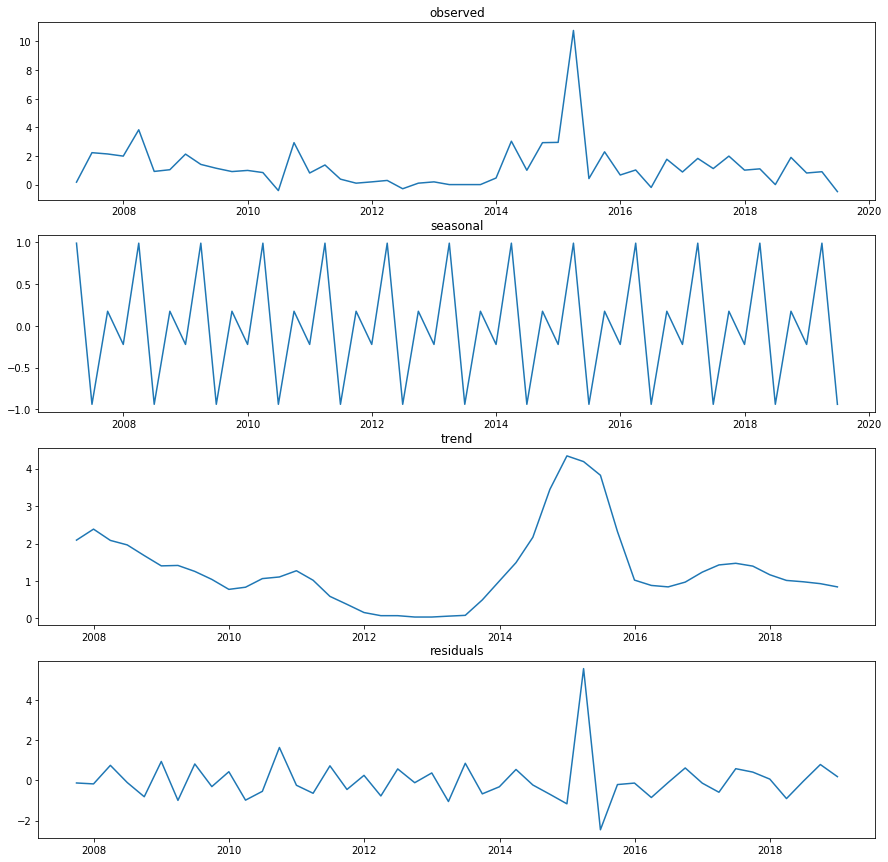

In [0]:
seasonal(y_CPI_m)

<Figure size 1440x1440 with 0 Axes>

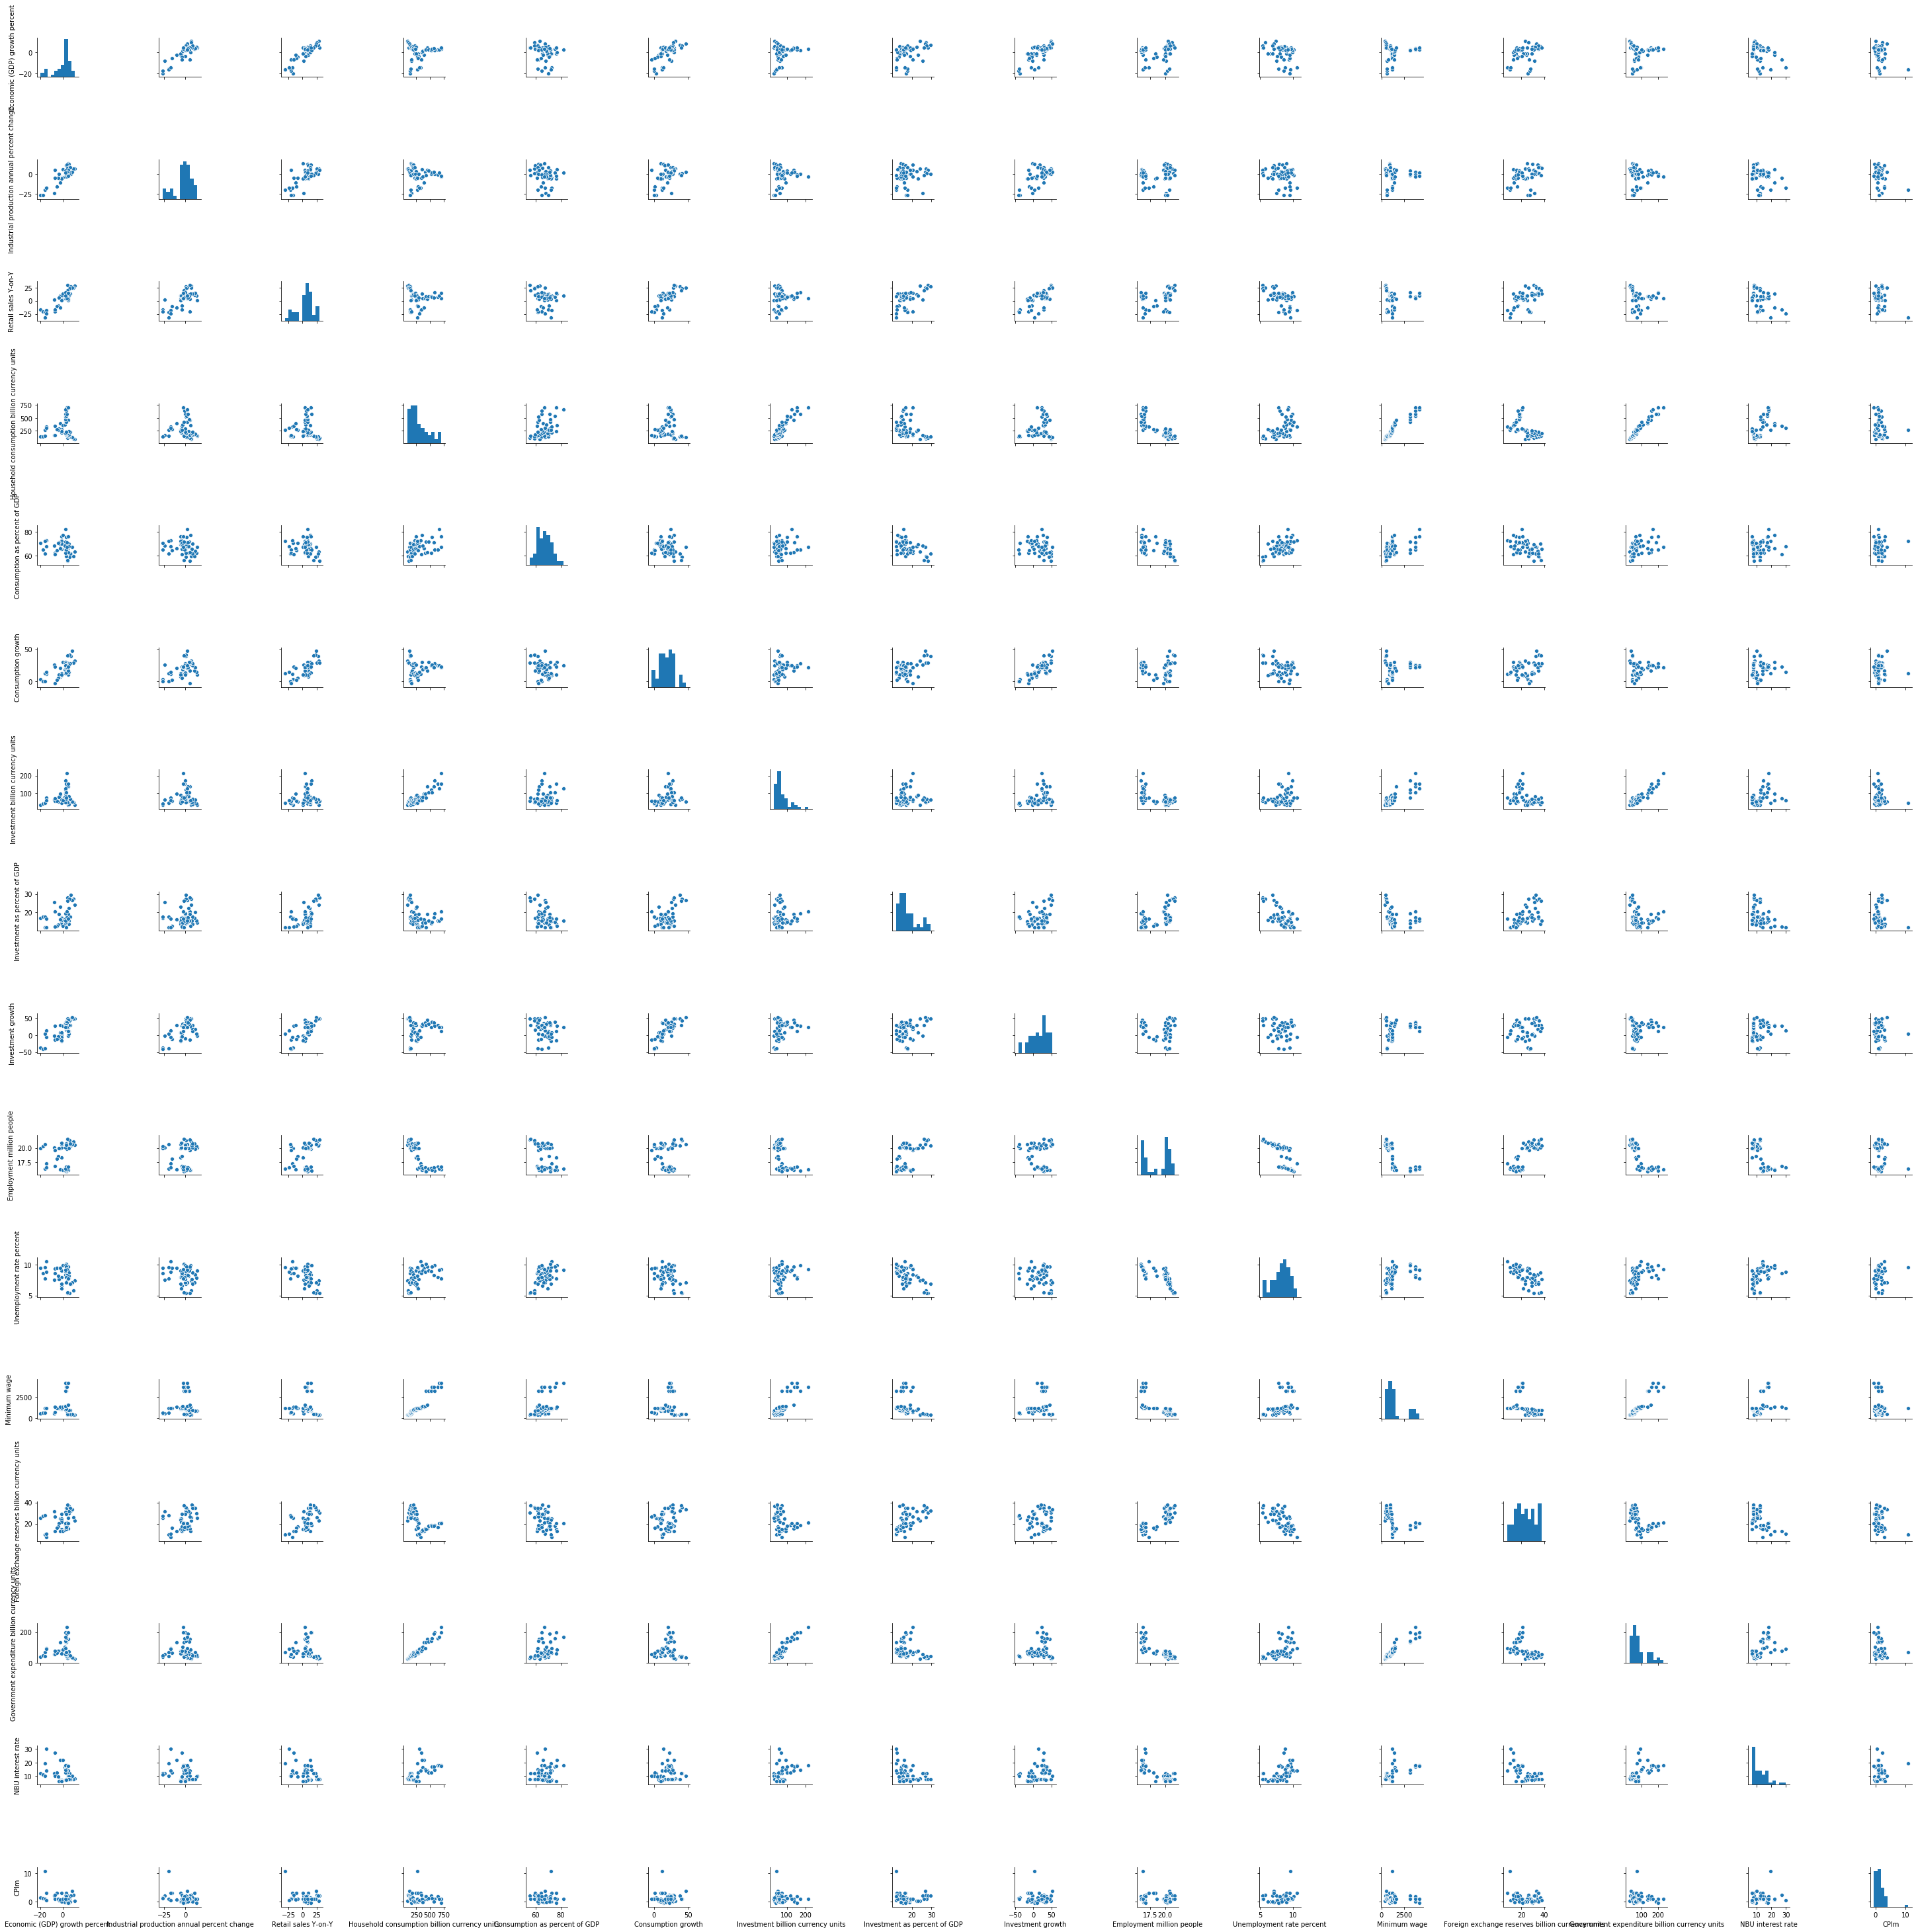

In [0]:
pairplot(xy_CPI_m)

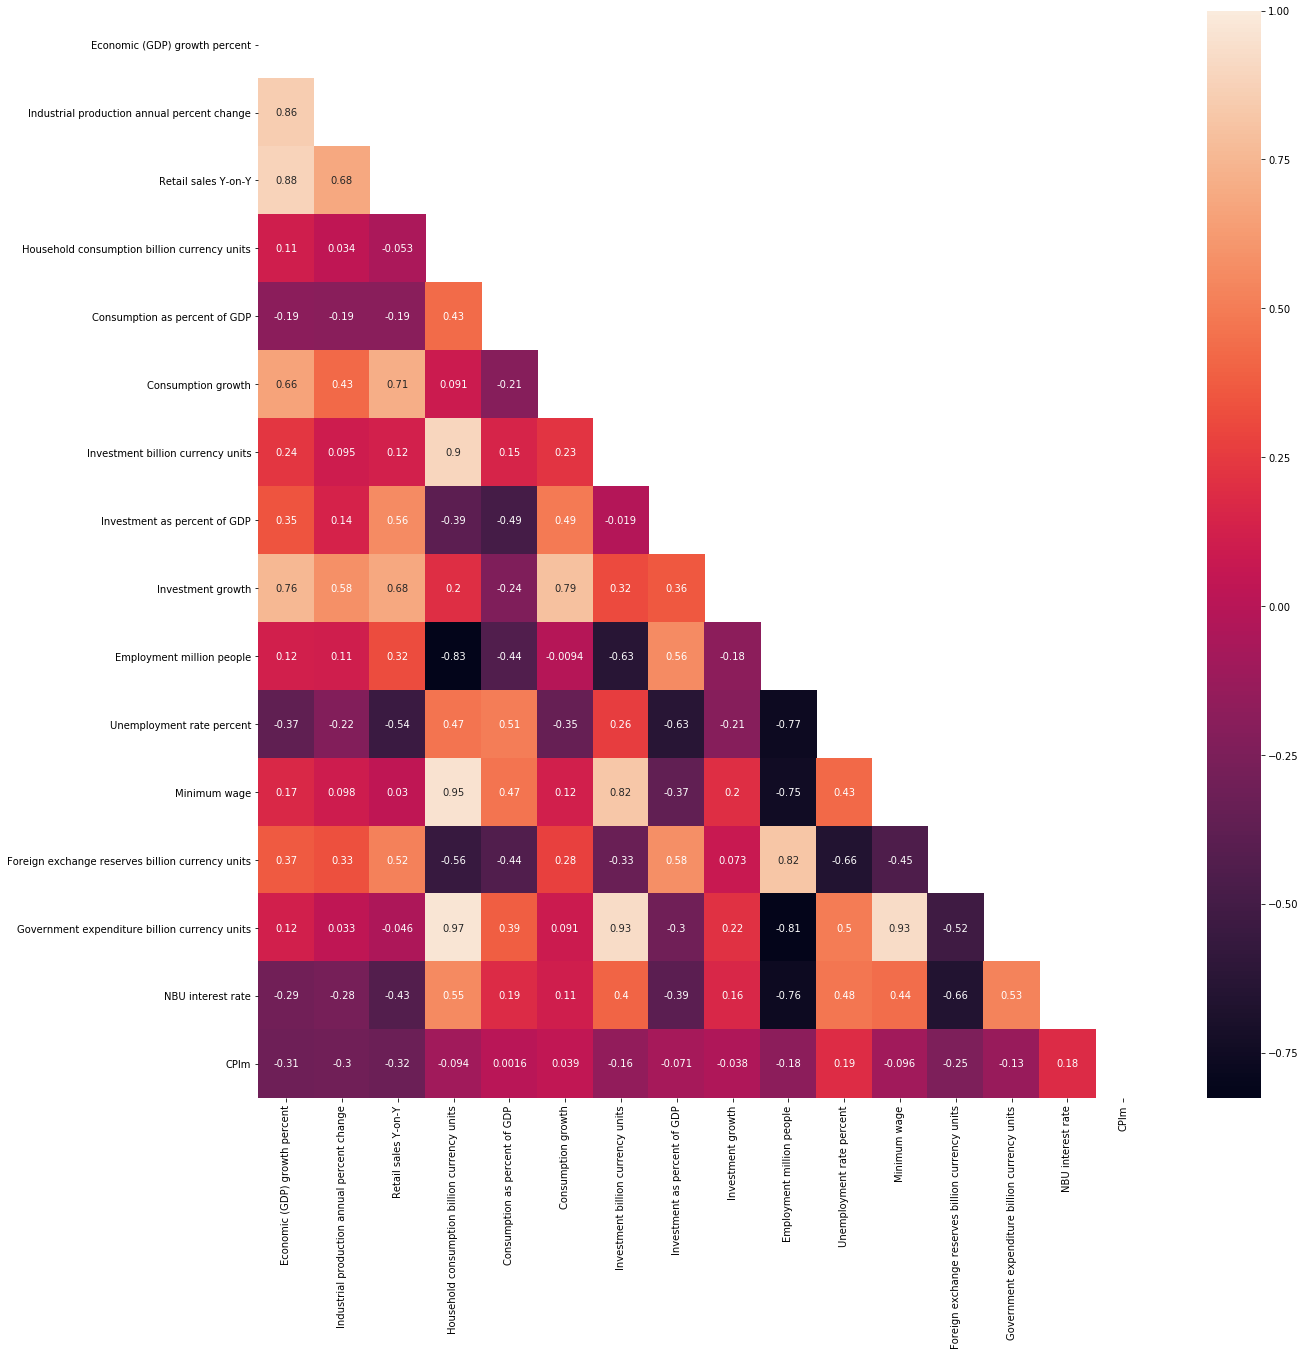

In [0]:
corrplot(xy_CPI_m)

### 3. CPI yearly percent change

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_CPI_y.index, y=y_CPI_y,
                    mode='lines',
                    name='CPI yearly percent change'))

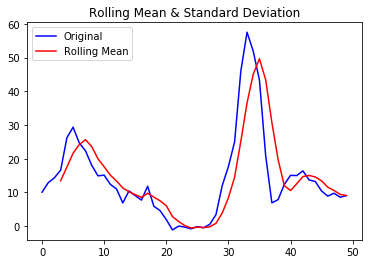

In [0]:
rolling(y_CPI_y, window=4)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



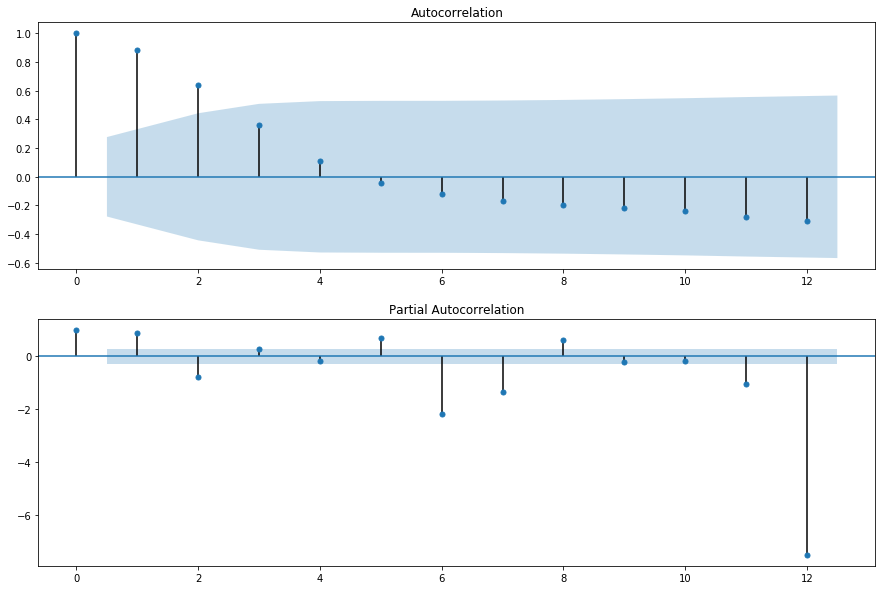

In [0]:
autocorr(y_CPI_y, max_lag=12)

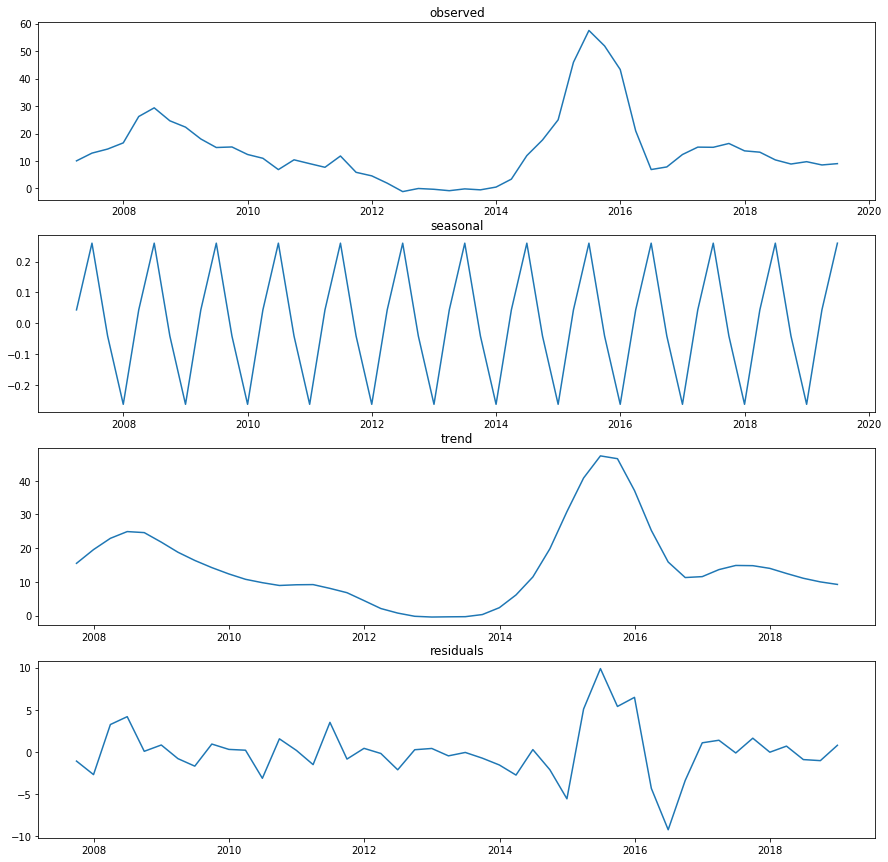

In [0]:
seasonal(y_CPI_y)

<Figure size 1440x1440 with 0 Axes>

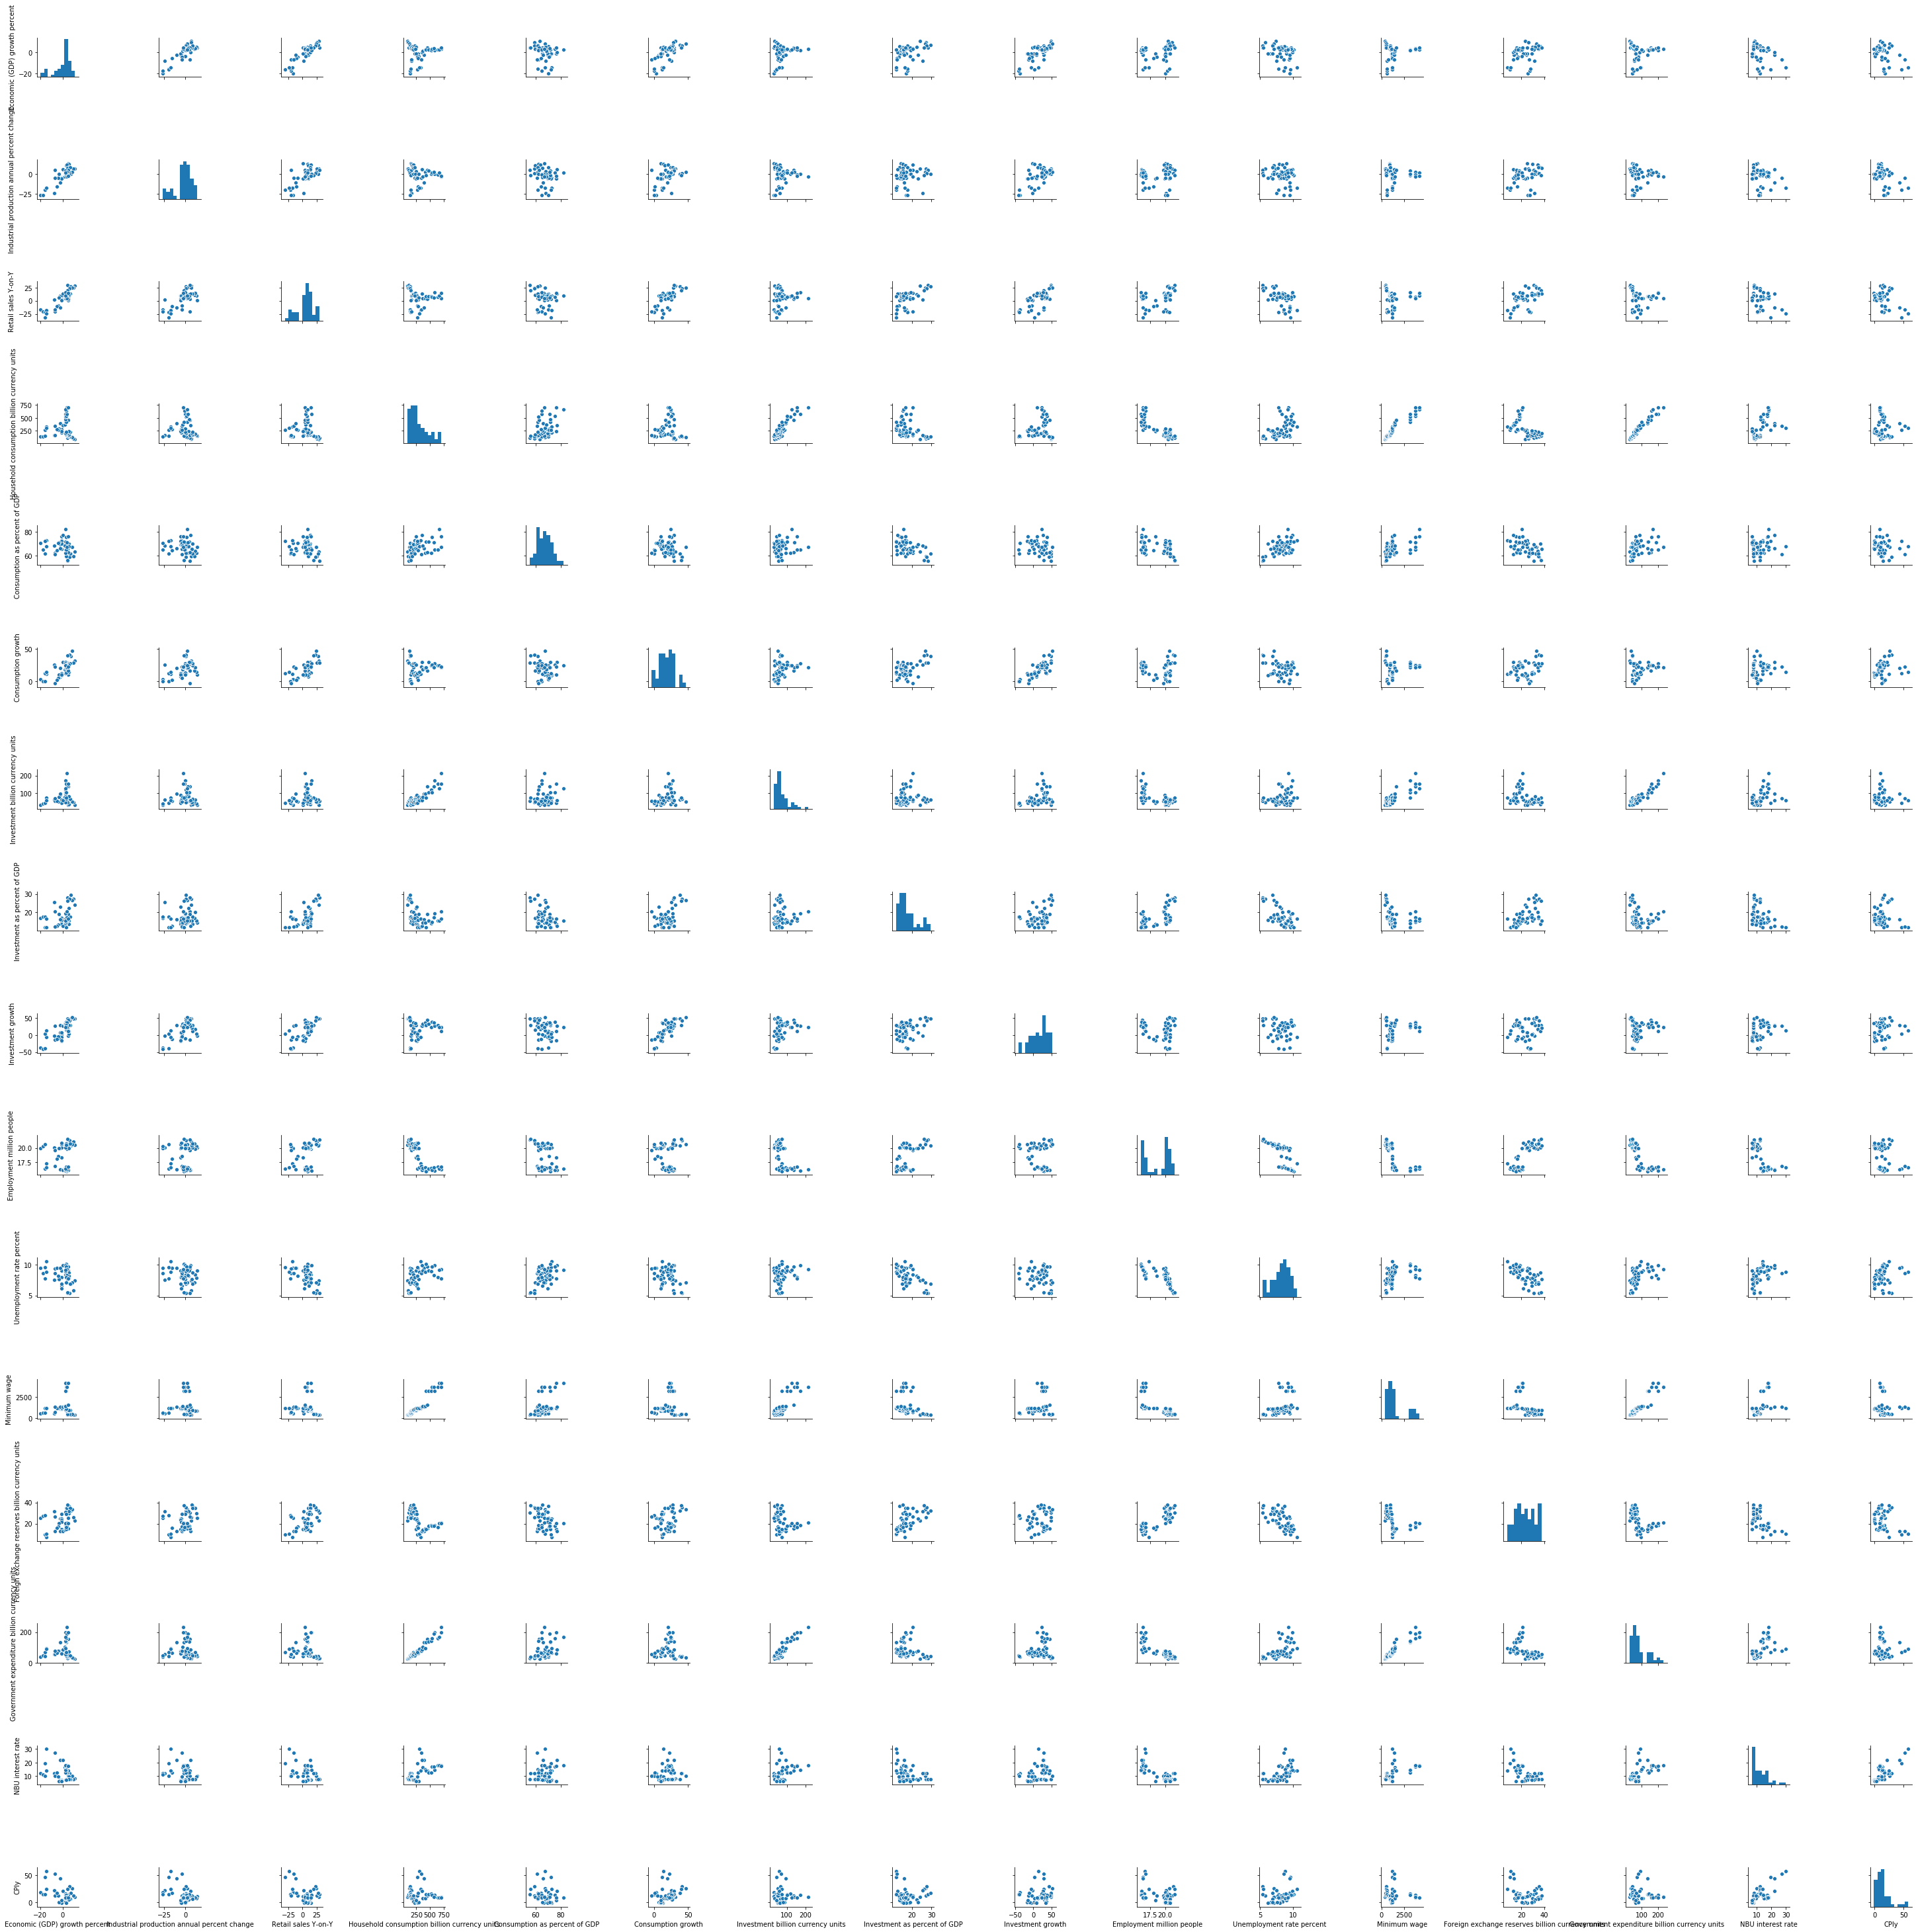

In [0]:
pairplot(xy_CPI_y)

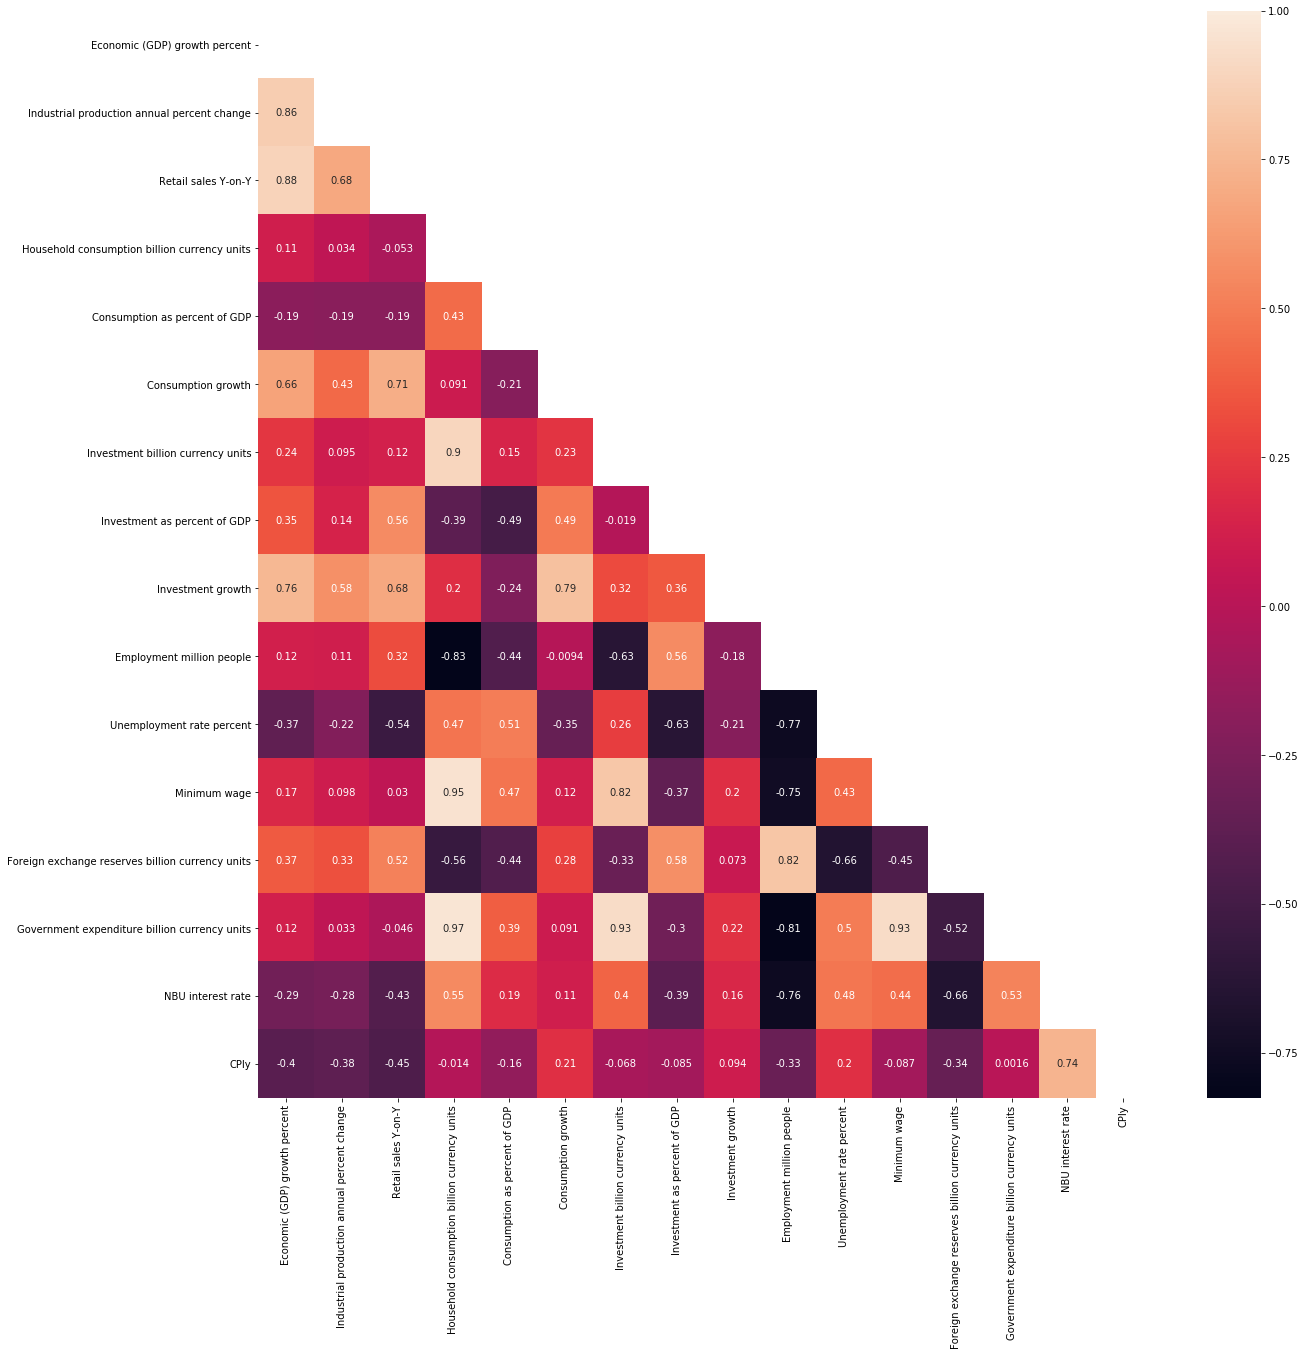

In [0]:
corrplot(xy_CPI_y)

# Time Series Analysis

1. ARIMA
2. ARIMAX
3. VARMA
4. VARMAX
5. SARIMAX
---------------
6. Facebook Prophet

## CPI


### @ARIMA - AutoRegressive Integrated Moving Average

In [0]:
def run_grid_search(model, trainset, testset, max_p, loss, **kwargs):
    """
    param max_p: max model parameters tuple
    param model: model to fit
    param loss:  loss function
    
    args, kwargs - for model
    """
    # form parameters' combinations
    param_ranges = [range(0, max_pi) for max_pi in max_p]
    
    param_product = list(itertools.product(*param_ranges))
    
    # define loss matrix
    losses = np.zeros(max_p)
        
    # for each params combination fit model & calculate loss
    for i in tqdm(range(len(param_product)), desc='param search'):
        params = param_product[i]
            
        try:
            if sum(params) == 0:
                raise Exception('damn this 0,0,0')
            
            mdl = model(trainset, params, **kwargs).fit()
            predict = mdl.predict(
                    testset.index[0],
                    testset.index[-1] + pd.DateOffset(months=3),
                    dynamic=True
                    )
            losses[params] = loss(predict, testset)
            print('succeed')
        except Exception as e:
            losses[params] = -1
            
    # pick up best parameters
    print(losses.sum())
    losses = np.nan_to_num(losses)
    losses[losses<=0] = np.max(losses)
    params = np.unravel_index(np.argmin(losses), losses.shape)
    
    return params

In [0]:
model = tsa.arima_model.ARIMA
max_p = (8, 3, 8)
parameters = run_grid_search(
    tsa.arima_model.ARIMA,
    y_CPI_train, y_CPI_test,
    max_p, metrics.mean_squared_error
)

In [0]:
parameters

(0, 0, 0)

In [0]:
def test_model(model, parameters, trainset, testset, **kwargs):
    """
    param parameters: model parameters
    param model: model to fit
    args, kwargs - for model too
    """
    mdl = model(trainset, parameters, **kwargs).fit()
    predict = mdl.predict(
                    testset.index[0],
                    testset.index[-1] + pd.DateOffset(months=3),
                    dynamic=True
                    )

    fig, ax = plt.subplots()
    ax.plot(predict.index, predict, label="Prediction")
    ax.plot(testset.index, testset, label="Test")
    fig.legend(loc='best')
    ax.set_title('Test')
    fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning:

Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.



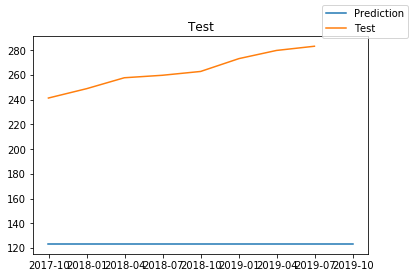

In [0]:
test_model(
    tsa.arima_model.ARIMA,
    parameters,
    y_CPI_train, y_CPI_test
)

### @ARIMAX with L2 loss

ARIMA with eXogenous regressors model




In [0]:
model = tsa.arima_model.ARIMA
loss = metrics.mean_squared_error

# form parameters' combinations
max_p = (8, 3, 8)
param_ranges = [range(0, max_pi) for max_pi in max_p]

param_product = list(itertools.product(*param_ranges))

# define loss matrix
losses = np.zeros(max_p)
    
# for each params combination fit model & calculate loss
for i in tqdm(range(len(param_product)), desc='param search'):
    params = param_product[i]
        
    try:
        if sum(params) == 0:
            raise Exception('damn this 0,0,0')
        
        mdl = model(y_CPI_train, params, exog=x_train).fit()
        predict = mdl.predict(
                y_CPI_test.index[0],
                y_CPI_test.index[-1],
                exog=x_test,
                dynamic=True
                )
        losses[params] = loss(predict, y_CPI_test)
        print('succeed')
    except Exception as e:
        print(e)
        losses[params] = -1
        
# pick up best parameters
print(losses.sum())
losses = np.nan_to_num(losses)
losses[losses<=0] = np.max(losses)
parameters = np.unravel_index(np.argmin(losses), losses.shape)
    

In [0]:
parameters

(4, 0, 0)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



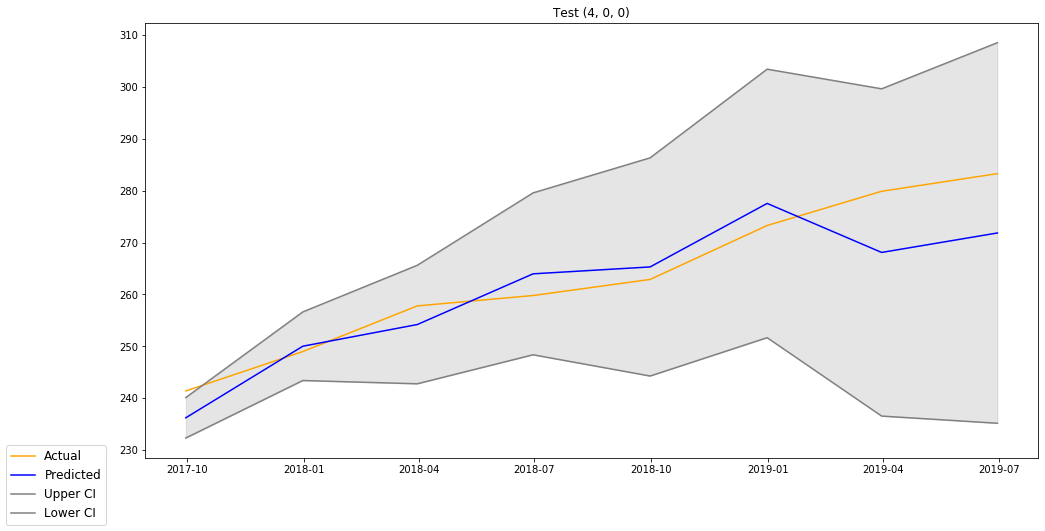

In [0]:
# fit model
model = tsa.arima_model.ARIMA
testset = y_CPI_test
mdl = model(y_CPI_train, (4,0,0), exog=x_train).fit()
predict = mdl.forecast(
                    len(testset.index),
                    exog=x_test
                    )

# get prediction & confidence interval
prediction = pd.Series(predict[0], index=y_CPI_test.index)
upper = pd.Series(predict[2][:,0], index=y_CPI_test.index)
lower = pd.Series(predict[2][:,1], index=y_CPI_test.index)

# plot results
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(y_CPI_test.index, y_CPI_test, color = 'orange', label = 'Actual')
ax1.plot(y_CPI_test.index, prediction, color = 'blue',label = 'Predicted' )
ax1.plot(y_CPI_test.index, upper, color = 'grey', label = 'Upper CI')
ax1.plot(y_CPI_test.index,lower, color = 'grey', label = 'Lower CI')
fig.legend(loc = 'lower left', fontsize = 12)
plt.fill_between(x, lower, upper, color='grey', alpha='0.2')
ax1.set_title(f'Test {(4,0,0)}')
fig.show()

In [0]:
mdl.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    CPI   No. Observations:                   42
Model:                     ARMA(4, 0)   Log Likelihood                 -95.063
Method:                       css-mle   S.D. of innovations              1.990
Date:                Mon, 17 Feb 2020   AIC                            232.126
Time:                        19:31:29   BIC                            268.617
Sample:                    03-31-2007   HQIC                           245.501
                         - 06-30-2017                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                              389.9834   1154.750      0.338      0.739   -1873.285    2653.252
Economic (GDP) growth percent                       -0.0574      0.106     -0.543      0.593      -0.265       0.150
Industrial production annual percent change          0.0207      0.050      0.412      0.684      -0.078       0.119
Retail sales Y-on-Y                                 -0.2216      0.054     -4.121      0.000      -0.327      -0.116
Household consumption billion currency units        -0.1079      0.032     -3.416      0.002      -0.170      -0.046
Consumption as percent of GDP                        0.4543      0.158      2.884      0.009       0.146       0.763
Consumption growth                                  -0.0267      0.073     -0.366      0.718      -0.170       0.116
Investment billion currency units                    0.3978      0.118      3.359      0.003       0.166       0.630
Investment as percent of GDP                        -1.4653      0.383     -3.827      0.001      -2.216      -0.715
Investment growth                                    0.0566      0.028      1.996      0.058       0.001       0.112
Employment million people                           -3.7537      1.141     -3.291      0.003      -5.990      -1.518
Unemployment rate percent                           -2.2958      0.542     -4.237      0.000      -3.358      -1.234
Minimum wage                                         0.0093      0.002      3.880      0.001       0.005       0.014
Foreign exchange reserves billion currency units     0.3054      0.127      2.404      0.025       0.056       0.554
Government expenditure billion currency units       -0.0611      0.039     -1.560      0.133      -0.138       0.016
NBU interest rate                                    1.6916      0.117     14.497      0.000       1.463       1.920
ar.L1.CPI                                            1.3693      0.008    168.054      0.000       1.353       1.385
ar.L2.CPI                                            0.5136        nan        nan        nan         nan         nan
ar.L3.CPI                                           -1.2483        nan        nan        nan         nan         nan
ar.L4.CPI                                            0.3651      0.009     42.852      0.000       0.348       0.382
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0468           +0.0000j            1.0468            0.5000
AR.2            1.0023           +0.0000j            1.0023            0.0000
AR.3            1.1084           +0.0000j            1.1084            0.0000
AR.4

In [0]:
print(f'L2 norm: {metrics.mean_squared_error(prediction, y_CPI_test)}')
print(f'dtw dist: {dtw.distance(prediction, y_CPI_test)}')

L2 norm: 44.01693006549522
dtw dist: 17.453708780488697


### @ARIMAX with DTW loss

Dynamic time warping as loss

In [0]:
model = tsa.arima_model.ARIMA
loss = dtw.distance

# form parameters' combinations
max_p = (8, 3, 8)
param_ranges = [range(0, max_pi) for max_pi in max_p]

param_product = list(itertools.product(*param_ranges))

# define loss matrix
losses = np.zeros(max_p)
    
# for each params combination fit model & calculate loss
for i in tqdm(range(len(param_product)), desc='param search'):
    params = param_product[i]
        
    try:
        if sum(params) == 0:
            raise Exception('damn this 0,0,0')
        
        mdl = model(y_CPI_train, params, exog=x_train).fit()
        predict = mdl.predict(
                y_CPI_test.index[0],
                y_CPI_test.index[-1],
                exog=x_test,
                dynamic=True
                )
        losses[params] = loss(predict, y_CPI_test)
        print('succeed')
    except Exception as e:
        print(e)
        losses[params] = -1
        
# pick up best parameters
print(losses.sum())
losses = np.nan_to_num(losses)
losses[losses<=0] = np.max(losses)
parameters = np.unravel_index(np.argmin(losses), losses.shape)
    

In [0]:
parameters

(3, 0, 3)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



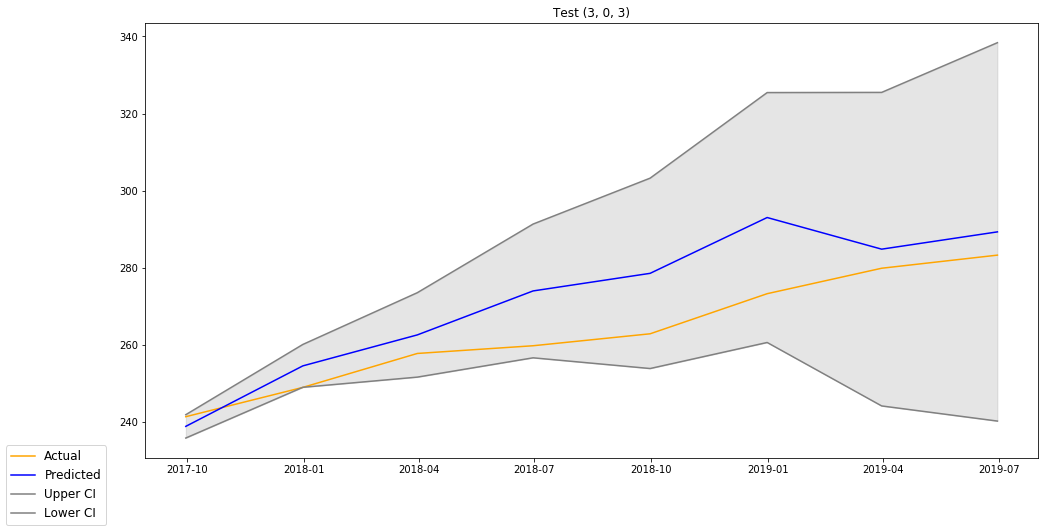

In [0]:
# get forecast
testset = y_CPI_test
mdl = model(y_CPI_train, (3,0,3), exog=x_train).fit()
predict = mdl.forecast(
                    len(testset.index),
                    exog=x_test
                    )

# get prediction & confidence interval
prediction = pd.Series(predict[0], index=y_CPI_test.index)
upper = pd.Series(predict[2][:,0], index=y_CPI_test.index)
lower = pd.Series(predict[2][:,1], index=y_CPI_test.index)

# plot results
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(y_CPI_test.index, y_CPI_test, color = 'orange', label = 'Actual')
ax1.plot(y_CPI_test.index, prediction, color = 'blue',label = 'Predicted' )
ax1.plot(y_CPI_test.index, upper, color = 'grey', label = 'Upper CI')
ax1.plot(y_CPI_test.index,lower, color = 'grey', label = 'Lower CI')
fig.legend(loc = 'lower left', fontsize = 12)
plt.fill_between(x, lower, upper, color='grey', alpha='0.2')
ax1.set_title(f'Test {(3,0,3)}')
fig.show()

In [0]:
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    CPI   No. Observations:                   42
Model:                     ARMA(3, 3)   Log Likelihood                 -88.554
Method:                       css-mle   S.D. of innovations              1.544
Date:                Mon, 17 Feb 2020   AIC                            223.109
Time:                        19:37:51   BIC                            263.075
Sample:                    03-31-2007   HQIC                           237.758
                         - 06-30-2017                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                              389.6664    654.879      0.595      0.559    -893.873    1673.206
Economic (GDP) growth percent                       -0.0607      0.097     -0.624      0.540      -0.251       0.130
Industrial production annual percent change         -0.0484      0.047     -1.032      0.314      -0.140       0.044
Retail sales Y-on-Y                                 -0.3013      0.048     -6.244      0.000      -0.396      -0.207
Household consumption billion currency units        -0.1291      0.021     -6.162      0.000      -0.170      -0.088
Consumption as percent of GDP                        0.5591      0.122      4.588      0.000       0.320       0.798
Consumption growth                                   0.0010      0.069      0.015      0.988      -0.134       0.136
Investment billion currency units                    0.4448      0.078      5.708      0.000       0.292       0.598
Investment as percent of GDP                        -1.4777      0.234     -6.312      0.000      -1.937      -1.019
Investment growth                                    0.0583      0.029      2.013      0.058       0.002       0.115
Employment million people                           -2.3524      0.759     -3.101      0.006      -3.839      -0.866
Unemployment rate percent                           -2.0070      0.416     -4.827      0.000      -2.822      -1.192
Minimum wage                                         0.0084      0.002      4.199      0.000       0.004       0.012
Foreign exchange reserves billion currency units     0.2486      0.134      1.852      0.079      -0.015       0.512
Government expenditure billion currency units       -0.0691      0.027     -2.514      0.021      -0.123      -0.015
NBU interest rate                                    1.8433      0.105     17.596      0.000       1.638       2.049
ar.L1.CPI                                            0.9449        nan        nan        nan         nan         nan
ar.L2.CPI                                            0.9648        nan        nan        nan         nan         nan
ar.L3.CPI                                           -0.9099      0.028    -32.525      0.000      -0.965      -0.855
ma.L1.CPI                                            0.5957      0.173      3.451      0.003       0.257       0.934
ma.L2.CPI                                            0.6967      0.191      3.655      0.002       0.323       1.070
ma.L3.CPI                                            0.9240      0.099      9.377      0.000       0.731       1.117
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1

In [0]:
print(f'L2 norm: {metrics.mean_squared_error(prediction, y_CPI_test)}')
print(f'dtw dist: {dtw.distance(prediction, y_CPI_test)}')

L2 norm: 119.92836673093396
dtw dist: 13.852516466965893


### ARIMAX with L2 loss & linear trend

In [0]:
import statsmodels
print(statsmodels.__version__)

0.10.2


In [0]:
model = tsa.arima.model.ARIMA
loss = metrics.mean_squared_error

# form parameters' combinations
max_p = (8, 3, 8)
param_ranges = [range(0, max_pi) for max_pi in max_p]

param_product = list(itertools.product(*param_ranges))

# define loss matrix
losses = np.zeros(max_p)
    
# for each params combination fit model & calculate loss
for i in tqdm(range(len(param_product)), desc='param search'):
    params = param_product[i]
        
    try:
        if sum(params) == 0:
            raise Exception('damn this 0,0,0')
        
        mdl = model(y_CPI_train, order=params, exog=x_train, trend=[1,1]).fit()
        predict = mdl.predict(
                y_CPI_test.index[0],
                y_CPI_test.index[-1],
                exog=x_test,
                dynamic=True
                )
        losses[params] = loss(predict, y_CPI_test)
        print('succeed')
    except Exception as e:
        print(e)
        losses[params] = -1
        
# pick up best parameters
print(losses.sum())
losses = np.nan_to_num(losses)
losses[losses<=0] = np.max(losses)
parameters = np.unravel_index(np.argmin(losses), losses.shape)
    

AttributeError: ignored

In [0]:
parameters

In [0]:
# fit model
model = tsa.arima_model.ARIMA
testset = y_CPI_test
mdl = model(y_CPI_train, parameters, exog=x_train, trend=[1,1]).fit()
predict = mdl.forecast(
                    len(testset.index),
                    exog=x_test
                    )

# get prediction & confidence interval
prediction = pd.Series(predict[0], index=y_CPI_test.index)
upper = pd.Series(predict[2][:,0], index=y_CPI_test.index)
lower = pd.Series(predict[2][:,1], index=y_CPI_test.index)

# plot results
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(y_CPI_test.index, y_CPI_test, color = 'orange', label = 'Actual')
ax1.plot(y_CPI_test.index, prediction, color = 'blue',label = 'Predicted' )
ax1.plot(y_CPI_test.index, upper, color = 'grey', label = 'Upper CI')
ax1.plot(y_CPI_test.index,lower, color = 'grey', label = 'Lower CI')
fig.legend(loc = 'lower left', fontsize = 12)
plt.fill_between(x, lower, upper, color='grey', alpha='0.2')
ax1.set_title(f'Test {parameters}')
fig.show()

In [0]:
mdl.summary()

In [0]:
print(f'L2 norm: {metrics.mean_squared_error(prediction, y_CPI_test)}')
print(f'dtw dist: {dtw.distance(prediction, y_CPI_test)}')

### VAR - Vector AutoRegression - NotImplementedError

This one includes impulse response analysis

### VARMAX - Vector Autoregressive Moving Average with eXogenous regressors model

added linear trend

this may come with impulse responses, too.

In [0]:
mdl = tsa.statespace.varmax.VARMAX(
    xy_CPI_train, order=(1,0),trend=[1,1]
).fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/varmax.py:357: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [0]:
predict = mdl.predict(
                xy_CPI_test.index[0],
                xy_CPI_test.index[-1],
                dynamic=True
                )

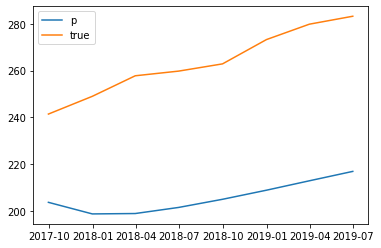

In [0]:
plt.plot(xy_CPI_test.index, predict['CPI'], label='p')
plt.plot(xy_CPI_test.index, xy_CPI_test['CPI'], label='true')
plt.legend()

In [0]:
model = tsa.statespace.varmax.VARMAX
loss = metrics.mean_squared_error

# form parameters' combinations
max_p = (8, 8)
param_ranges = [range(0, max_pi) for max_pi in max_p]

param_product = list(itertools.product(*param_ranges))

# define loss matrix
losses_cpi = np.zeros(max_p)
losses_general = np.zeros(max_p)
    
# for each params combination fit model & calculate loss
for i in tqdm(range(len(param_product)), desc='param search'):
    params = param_product[i]
        
    try:
        if sum(params) == 0:
            raise Exception('damn this 0,0,0')
        
        mdl = model(xy_CPI_train, order=params, trend=[1,1]).fit()
        predict = mdl.predict(
                xy_CPI_test.index[0],
                xy_CPI_test.index[-1],
                dynamic=True
                )
        losses_cpi[params] = loss(predict['CPI'], xy_CPI_test['CPI'])
        losses_general[params] = loss(predict, xy_CPI_test)
        print('succeed')
    except Exception as e:
        print(e)
        losses_cpi[params] = -1
        losses_general[params] = -1
        
# pick up best parameters
# print(losses.sum())
losses_cpi = np.nan_to_num(losses_cpi)
losses_general = np.nan_to_num(losses_general)
losses_cpi[losses_cpi<=0] = np.max(losses_cpi)
losses_general[losses_general<=0] = np.max(losses_general)
parameters_cpi = np.unravel_index(np.argmin(losses_cpi), losses_cpi.shape)
parameters_general = np.unravel_index(np.argmin(losses_general), losses_general.shape)
    

param search:   0%|          | 0/64 [00:00<?, ?it/s]

damn this 0,0,0


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

param search:   3%|▎         | 2/64 [01:10<36:34, 35.40s/it]

succeed


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/varmax.py:379: UserWarning:

Non-stationary starting moving-average parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

param search:   5%|▍         | 3/64 [03:35<1:09:24, 68.26s/it]

succeed


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/varmax.py:379: UserWarning:

Non-stationary starting moving-average parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

param search:   6%|▋         | 4/64 [07:58<2:06:37, 126.62s/it]

succeed


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/varmax.py:379: UserWarning:

Non-stationary starting moving-average parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

param search:   8%|▊         | 5/64 [14:07<3:15:54, 199.22s/it]

succeed


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/varmax.py:379: UserWarning:

Non-stationary starting moving-average parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

param search:   9%|▉         | 6/64 [23:20<4:55:22, 305.56s/it]

succeed


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/varmax.py:379: UserWarning:

Non-stationary starting moving-average parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



KeyboardInterrupt: ignored

In [0]:
losses_cpi = np.nan_to_num(losses_cpi)
losses_general = np.nan_to_num(losses_general)
losses_cpi[losses_cpi<=0] = np.max(losses_cpi)
losses_general[losses_general<=0] = np.max(losses_general)
parameters_cpi = np.unravel_index(np.argmin(losses_cpi), losses_cpi.shape)
parameters_general = np.unravel_index(np.argmin(losses_general), losses_general.shape)
    

In [0]:
print(f'cpi fitting: {parameters_cpi}')
print(f'all da hell: {parameters_general}')

cpi fitting: (0, 1)
all da hell: (0, 1)


In [0]:
# fit model
tsa.statespace.varmax.VARMAX
testset = y_CPI_test
mdl = model(y_CPI_train, order=(0,1), trend=[1,1]).fit()
predict = mdl.forecast(
                    len(testset.index),
                    )

# get prediction & confidence interval
prediction = pd.Series(predict[0], index=y_CPI_test.index)
upper = pd.Series(predict[2][:,0], index=y_CPI_test.index)
lower = pd.Series(predict[2][:,1], index=y_CPI_test.index)

# plot results
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(y_CPI_test.index, y_CPI_test, color = 'orange', label = 'Actual')
ax1.plot(y_CPI_test.index, prediction, color = 'blue',label = 'Predicted' )
ax1.plot(y_CPI_test.index, upper, color = 'grey', label = 'Upper CI')
ax1.plot(y_CPI_test.index,lower, color = 'grey', label = 'Lower CI')
fig.legend(loc = 'lower left', fontsize = 12)
plt.fill_between(x, lower, upper, color='grey', alpha='0.2')
ax1.set_title(f'Test {(0,1)}')
fig.show()

IndexError: ignored

## CPI monthly percent change

### ARIMA - NotImplementedError

### @ARIMAX with L2 loss

In [0]:
model = tsa.arima_model.ARIMA
loss = metrics.mean_squared_error

# form parameters' combinations
max_p = (8, 3, 8)
param_ranges = [range(0, max_pi) for max_pi in max_p]

param_product = list(itertools.product(*param_ranges))

# define loss matrix
losses = np.zeros(max_p)
    
# for each params combination fit model & calculate loss
for i in tqdm(range(len(param_product)), desc='param search'):
    params = param_product[i]
        
    try:
        if sum(params) == 0:
            raise Exception('damn this 0,0,0')
        
        mdl = model(y_CPIm_train, params, exog=x_train).fit()
        predict = mdl.predict(
                y_CPIm_test.index[0],
                y_CPIm_test.index[-1],
                exog=x_test,
                dynamic=True
                )
        losses[params] = loss(predict, y_CPIm_test)
        print('succeed')
    except Exception as e:
        print(e)
        losses[params] = -1
        
# pick up best parameters
print(losses.sum())
losses = np.nan_to_num(losses)
losses[losses<=0] = np.max(losses)
parameters = np.unravel_index(np.argmin(losses), losses.shape)
    

In [0]:
parameters

(3, 2, 2)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



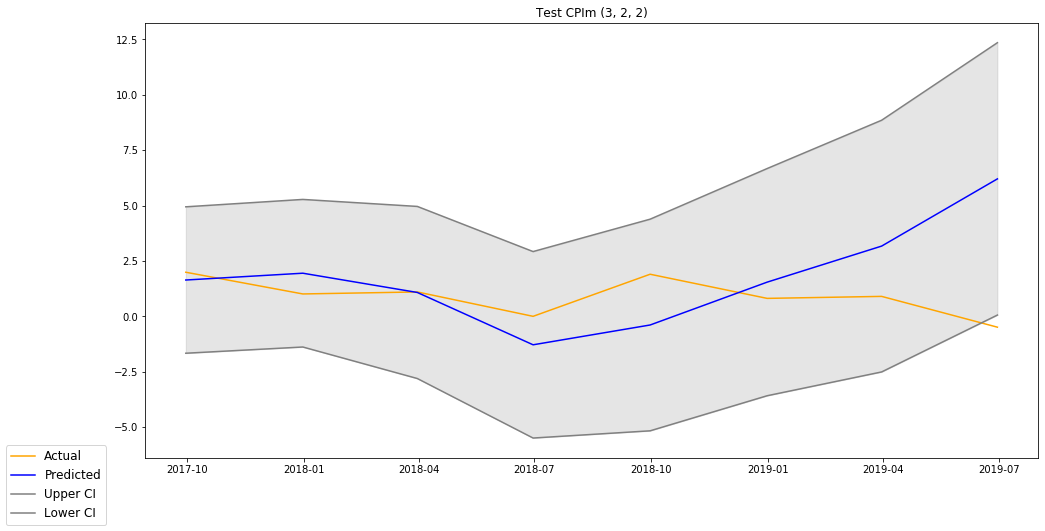

In [0]:
# fit model
model = tsa.arima_model.ARIMA
testset = y_CPIm_test
mdl = model(y_CPIm_train, parameters, exog=x_train).fit()
predict = mdl.forecast(
                    len(testset.index),
                    exog=x_test
                    )

# get prediction & confidence interval
prediction = pd.Series(predict[0], index=y_CPIm_test.index)
upper = pd.Series(predict[2][:,0], index=y_CPIm_test.index)
lower = pd.Series(predict[2][:,1], index=y_CPIm_test.index)

# plot results
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(y_CPIm_test.index, y_CPIm_test, color = 'orange', label = 'Actual')
ax1.plot(y_CPIm_test.index, prediction, color = 'blue',label = 'Predicted' )
ax1.plot(y_CPIm_test.index, upper, color = 'grey', label = 'Upper CI')
ax1.plot(y_CPIm_test.index,lower, color = 'grey', label = 'Lower CI')
fig.legend(loc = 'lower left', fontsize = 12)
plt.fill_between(x, lower, upper, color='grey', alpha='0.2')
ax1.set_title(f'Test CPIm {parameters}')
fig.show()

In [0]:
mdl.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



<class 'statsmodels.iolib.summary.Summary'>
"""
                                   ARIMA Model Results                                   
=========================================================================================
Dep. Variable:     D2.CPI monthly percent change   No. Observations:                   40
Model:                            ARIMA(3, 2, 2)   Log Likelihood                 -79.780
Method:                                  css-mle   S.D. of innovations              1.686
Date:                           Mon, 17 Feb 2020   AIC                            203.560
Time:                                   20:47:57   BIC                            240.715
Sample:                               09-30-2007   HQIC                           216.994
                                    - 06-30-2017                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               25.9230        nan        nan        nan         nan         nan
Economic (GDP) growth percent                        0.3177      0.146      2.179      0.042       0.032       0.604
Industrial production annual percent change         -0.1240      0.059     -2.112      0.048      -0.239      -0.009
Retail sales Y-on-Y                                  0.0362      0.031      1.177      0.254      -0.024       0.097
Household consumption billion currency units         0.0013      0.034      0.040      0.969      -0.065       0.068
Consumption as percent of GDP                       -0.0924      0.099     -0.929      0.364      -0.287       0.102
Consumption growth                                  -0.0648      0.035     -1.847      0.080      -0.133       0.004
Investment billion currency units                    0.0587      0.089      0.656      0.520      -0.117       0.234
Investment as percent of GDP                        -0.1598      0.298     -0.536      0.598      -0.745       0.425
Investment growth                                   -0.0547      0.006     -8.807      0.000      -0.067      -0.043
Employment million people                           -0.7864      0.333     -2.360      0.029      -1.439      -0.133
Unemployment rate percent                           -0.2705        nan        nan        nan         nan         nan
Minimum wage                                         0.0006        nan        nan        nan         nan         nan
Foreign exchange reserves billion currency units     0.0560      0.073      0.771      0.450      -0.086       0.198
Government expenditure billion currency units       -0.0796        nan        nan        nan         nan         nan
NBU interest rate                                    0.1383      0.041      3.334      0.003       0.057       0.220
ar.L1.D2.CPI monthly percent change                 -1.0393      0.170     -6.099      0.000      -1.373      -0.705
ar.L2.D2.CPI monthly percent change                 -0.5624      0.287     -1.960      0.065      -1.125   -6.41e-05
ar.L3.D2.CPI monthly percent change                 -0.2414      0.199     -1.213      0.240      -0.632       0.149
ma.L1.D2.CPI monthly percent change                 -0.8340        nan        nan        nan         nan         nan
ma.L2.D2.CPI monthly percent change                 -0.0333        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3828

In [0]:
print(f'L2 norm: {metrics.mean_squared_error(prediction, y_CPIm_test)}')
print(f'dtw dist: {dtw.distance(prediction, y_CPIm_test)}')

L2 norm: 7.301529674903046
dtw dist: 7.250696558859996


### @ARIMAX with DTW dist

Совпало с L2

In [0]:
model = tsa.arima_model.ARIMA
loss = dtw.distance

# form parameters' combinations
max_p = (8, 3, 8)
param_ranges = [range(0, max_pi) for max_pi in max_p]

param_product = list(itertools.product(*param_ranges))

# define loss matrix
losses = np.zeros(max_p)
    
# for each params combination fit model & calculate loss
for i in tqdm(range(len(param_product)), desc='param search'):
    params = param_product[i]
        
    try:
        if sum(params) == 0:
            raise Exception('damn this 0,0,0')
        
        mdl = model(y_CPIm_train, params, exog=x_train).fit()
        predict = mdl.predict(
                y_CPIm_test.index[0],
                y_CPIm_test.index[-1],
                exog=x_test,
                dynamic=True
                )
        losses[params] = loss(predict, y_CPIm_test)
        print('succeed')
    except Exception as e:
        print(e)
        losses[params] = -1
        
# pick up best parameters
print(losses.sum())
losses = np.nan_to_num(losses)
losses[losses<=0] = np.max(losses)
parameters = np.unravel_index(np.argmin(losses), losses.shape)
    

In [0]:
parameters

(3, 2, 2)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



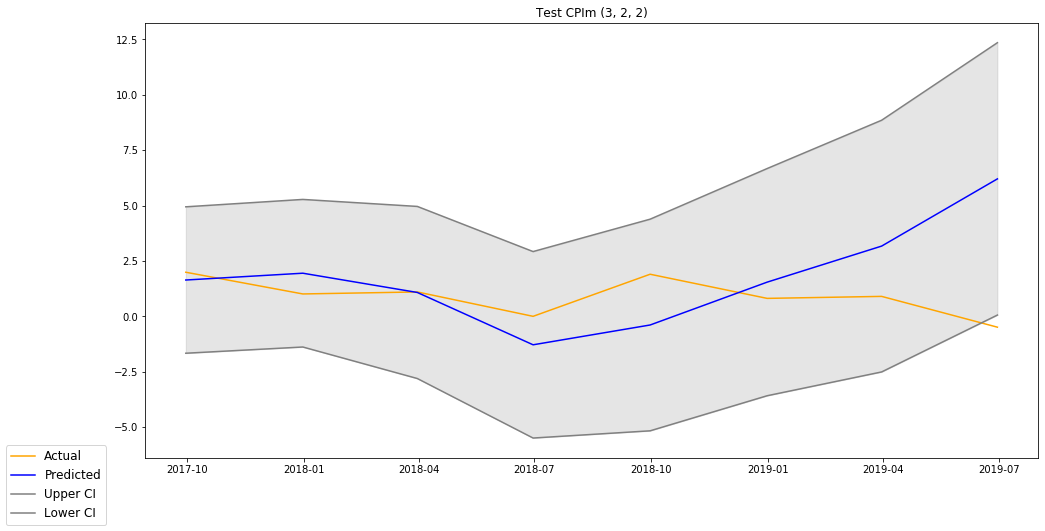

In [0]:
# fit model
model = tsa.arima_model.ARIMA
testset = y_CPIm_test
mdl = model(y_CPIm_train, parameters, exog=x_train).fit()
predict = mdl.forecast(
                    len(testset.index),
                    exog=x_test
                    )

# get prediction & confidence interval
prediction = pd.Series(predict[0], index=y_CPIm_test.index)
upper = pd.Series(predict[2][:,0], index=y_CPIm_test.index)
lower = pd.Series(predict[2][:,1], index=y_CPIm_test.index)

# plot results
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(y_CPIm_test.index, y_CPIm_test, color = 'orange', label = 'Actual')
ax1.plot(y_CPIm_test.index, prediction, color = 'blue',label = 'Predicted' )
ax1.plot(y_CPIm_test.index, upper, color = 'grey', label = 'Upper CI')
ax1.plot(y_CPIm_test.index,lower, color = 'grey', label = 'Lower CI')
fig.legend(loc = 'lower left', fontsize = 12)
plt.fill_between(x, lower, upper, color='grey', alpha='0.2')
ax1.set_title(f'Test CPIm {parameters}')
fig.show()

In [0]:
mdl.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



<class 'statsmodels.iolib.summary.Summary'>
"""
                                   ARIMA Model Results                                   
=========================================================================================
Dep. Variable:     D2.CPI monthly percent change   No. Observations:                   40
Model:                            ARIMA(3, 2, 2)   Log Likelihood                 -79.780
Method:                                  css-mle   S.D. of innovations              1.686
Date:                           Mon, 17 Feb 2020   AIC                            203.560
Time:                                   21:19:15   BIC                            240.715
Sample:                               09-30-2007   HQIC                           216.994
                                    - 06-30-2017                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               25.9230        nan        nan        nan         nan         nan
Economic (GDP) growth percent                        0.3177      0.146      2.179      0.042       0.032       0.604
Industrial production annual percent change         -0.1240      0.059     -2.112      0.048      -0.239      -0.009
Retail sales Y-on-Y                                  0.0362      0.031      1.177      0.254      -0.024       0.097
Household consumption billion currency units         0.0013      0.034      0.040      0.969      -0.065       0.068
Consumption as percent of GDP                       -0.0924      0.099     -0.929      0.364      -0.287       0.102
Consumption growth                                  -0.0648      0.035     -1.847      0.080      -0.133       0.004
Investment billion currency units                    0.0587      0.089      0.656      0.520      -0.117       0.234
Investment as percent of GDP                        -0.1598      0.298     -0.536      0.598      -0.745       0.425
Investment growth                                   -0.0547      0.006     -8.807      0.000      -0.067      -0.043
Employment million people                           -0.7864      0.333     -2.360      0.029      -1.439      -0.133
Unemployment rate percent                           -0.2705        nan        nan        nan         nan         nan
Minimum wage                                         0.0006        nan        nan        nan         nan         nan
Foreign exchange reserves billion currency units     0.0560      0.073      0.771      0.450      -0.086       0.198
Government expenditure billion currency units       -0.0796        nan        nan        nan         nan         nan
NBU interest rate                                    0.1383      0.041      3.334      0.003       0.057       0.220
ar.L1.D2.CPI monthly percent change                 -1.0393      0.170     -6.099      0.000      -1.373      -0.705
ar.L2.D2.CPI monthly percent change                 -0.5624      0.287     -1.960      0.065      -1.125   -6.41e-05
ar.L3.D2.CPI monthly percent change                 -0.2414      0.199     -1.213      0.240      -0.632       0.149
ma.L1.D2.CPI monthly percent change                 -0.8340        nan        nan        nan         nan         nan
ma.L2.D2.CPI monthly percent change                 -0.0333        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3828

In [0]:
print(f'L2 norm: {metrics.mean_squared_error(prediction, y_CPIm_test)}')
print(f'dtw dist: {dtw.distance(prediction, y_CPIm_test)}')

L2 norm: 7.301529674903046
dtw dist: 7.250696558859996


## CPI yearly percent change

### ARIMA - NotImplementedError

### @ARIMAX with L2 loss

In [0]:
model = tsa.arima_model.ARIMA
loss = metrics.mean_squared_error

# form parameters' combinations
max_p = (8, 3, 8)
param_ranges = [range(0, max_pi) for max_pi in max_p]

param_product = list(itertools.product(*param_ranges))

# define loss matrix
losses = np.zeros(max_p)
    
# for each params combination fit model & calculate loss
for i in tqdm(range(len(param_product)), desc='param search'):
    params = param_product[i]
        
    try:
        if sum(params) == 0:
            raise Exception('damn this 0,0,0')
        
        mdl = model(y_CPIy_train, params, exog=x_train).fit()
        predict = mdl.predict(
                y_CPIy_test.index[0],
                y_CPIy_test.index[-1],
                exog=x_test,
                dynamic=True
                )
        losses[params] = loss(predict, y_CPIy_test)
        print('succeed')
    except Exception as e:
        print(e)
        losses[params] = -1
        
# pick up best parameters
print(losses.sum())
losses = np.nan_to_num(losses)
losses[losses<=0] = np.max(losses)
parameters = np.unravel_index(np.argmin(losses), losses.shape)
    

In [0]:
parameters

(4, 0, 4)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



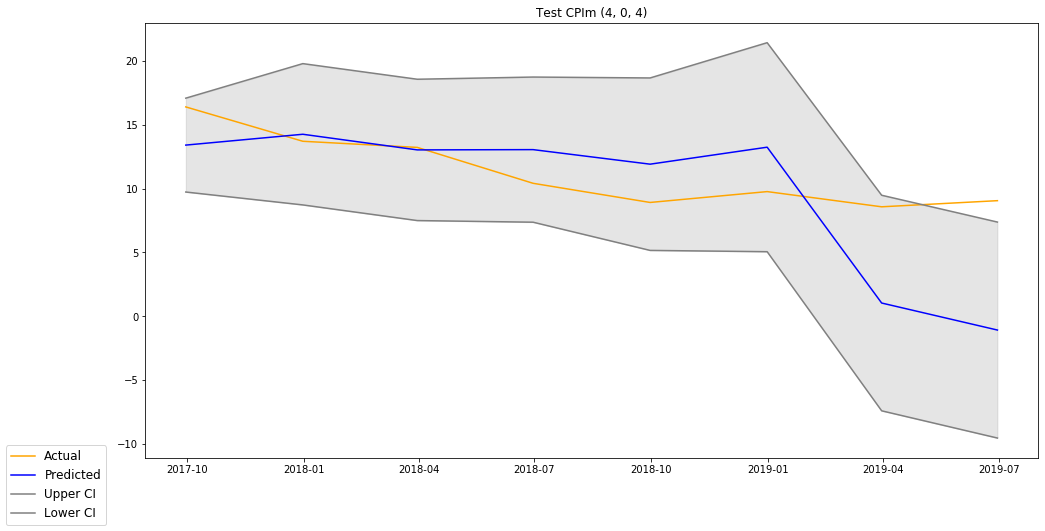

In [0]:
# fit model
model = tsa.arima_model.ARIMA
testset = y_CPIy_test
mdl = model(y_CPIy_train, parameters, exog=x_train).fit()
predict = mdl.forecast(
                    len(testset.index),
                    exog=x_test
                    )

# get prediction & confidence interval
prediction = pd.Series(predict[0], index=y_CPIy_test.index)
upper = pd.Series(predict[2][:,0], index=y_CPIy_test.index)
lower = pd.Series(predict[2][:,1], index=y_CPIy_test.index)

# plot results
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(y_CPIy_test.index, y_CPIy_test, color = 'orange', label = 'Actual')
ax1.plot(y_CPIy_test.index, prediction, color = 'blue',label = 'Predicted' )
ax1.plot(y_CPIy_test.index, upper, color = 'grey', label = 'Upper CI')
ax1.plot(y_CPIy_test.index,lower, color = 'grey', label = 'Lower CI')
fig.legend(loc = 'lower left', fontsize = 12)
plt.fill_between(x, lower, upper, color='grey', alpha='0.2')
ax1.set_title(f'Test CPIm {parameters}')
fig.show()

In [0]:
mdl.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                 
=====================================================================================
Dep. Variable:     CPI yearly percent change   No. Observations:                   42
Model:                            ARMA(4, 4)   Log Likelihood                 -90.589
Method:                              css-mle   S.D. of innovations              1.874
Date:                       Mon, 17 Feb 2020   AIC                            231.177
Time:                               22:04:34   BIC                            274.619
Sample:                           03-31-2007   HQIC                           247.101
                                - 06-30-2017                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               25.6276     27.360      0.937      0.361     -27.997      79.253
Economic (GDP) growth percent                        0.0388      0.188      0.207      0.838      -0.329       0.406
Industrial production annual percent change         -0.2454      0.098     -2.501      0.022      -0.438      -0.053
Retail sales Y-on-Y                                 -0.4853      0.107     -4.521      0.000      -0.696      -0.275
Household consumption billion currency units        -0.0954      0.040     -2.358      0.030      -0.175      -0.016
Consumption as percent of GDP                       -0.1959      0.160     -1.228      0.235      -0.509       0.117
Consumption growth                                   0.7443      0.226      3.296      0.004       0.302       1.187
Investment billion currency units                    0.1511      0.111      1.360      0.190      -0.067       0.369
Investment as percent of GDP                        -0.6557      0.311     -2.110      0.049      -1.265      -0.047
Investment growth                                   -0.0018      0.078     -0.023      0.982      -0.154       0.151
Employment million people                            0.1765      1.007      0.175      0.863      -1.797       2.150
Unemployment rate percent                           -0.0976      1.096     -0.089      0.930      -2.245       2.050
Minimum wage                                         0.0012      0.005      0.253      0.803      -0.008       0.010
Foreign exchange reserves billion currency units    -0.2723      0.278     -0.980      0.340      -0.817       0.272
Government expenditure billion currency units        0.0484      0.047      1.021      0.321      -0.045       0.141
NBU interest rate                                    1.3112      0.266      4.923      0.000       0.789       1.833
ar.L1.CPI yearly percent change                      0.5960      0.175      3.401      0.003       0.253       0.939
ar.L2.CPI yearly percent change                     -0.4213      0.117     -3.602      0.002      -0.651      -0.192
ar.L3.CPI yearly percent change                      0.6010      0.393      1.530      0.143      -0.169       1.371
ar.L4.CPI yearly percent change                     -0.7380      0.180     -4.096      0.001      -1.091      -0.385
ma.L1.CPI yearly percent change                      0.5295      0.354      1.494      0.153      -0.165       1.224
ma.L2.CPI yearly percent change                     -0.2247        nan        nan        nan         nan         nan
ma.L3.CPI yearly percent change                     -0.4948      0.336     -1.472      0.158      -1.154       0.164
ma.L4.CPI yearly percent change                     -0.7096        nan        nan        nan         nan         nan
                   

In [0]:
print(f'L2 norm: {metrics.mean_squared_error(prediction, y_CPIy_test)}')
print(f'dtw dist: {dtw.distance(prediction, y_CPIy_test)}')

L2 norm: 24.57819437709975
dtw dist: 13.854535186278296


# Regression - NotImplementedError

1. [Linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

2. [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)



3. Lasso



### Linear regression

In [0]:
# fit model and get predictions
mdl = lm.LinearRegression().fit(x_train, y_train)
prediction = mdl.predict(x_test)

# plot results
fig, ax = plt.subplots(nrows=3, figsize=(15,15))
ax[0].plot(y_test.index, y_test['CPI'], label='actual')
ax[0].plot(y_test.index, prediction['CPI'],label='predict')
ax[1].plot(y_test.index, y_test['CPI monthly percent change'], label='actual')
ax[1].plot(y_test.index, prediction['CPI monthly percent change'],label='predict')
ax[2].plot(y_test.index, y_test['CPI yearly percent change'], label='actual')
ax[2].plot(y_test.index, prediction['CPI yearly percent change'],label='predict')

NameError: ignored